In [1]:
"""

Code Description:
This scropit reads the cs100 source files and generates a summary report.


Author: Morteza
Version History:
- Version 1.0: September 11, 2025

To Do:


"""

'\n\nCode Description:\nThis scropit reads the cs100 source files and generates a summary report.\n\n\nAuthor: Morteza\nVersion History:\n- Version 1.0: September 11, 2025\n\nTo Do:\n\n\n'

# Import the dependencies

In [2]:
import sys
from pathlib import Path
import yaml
from typing import Tuple, Union, NamedTuple, Sequence, Dict, Any

import pandas as pd
import numpy as np
import xarray as xr
import geopandas
import pygmt

from scipy.stats import norm, kstest, cramervonmises, truncnorm, norm, weibull_min
from matplotlib import pyplot as plt
plt.rcParams.update({'font.size': 7})

sys.path.append(str(Path.cwd().parent))
from utils import util
from utils.util import a_to_mw_leonard, a_to_mw_skarlatoudis
# import seismic_hazard_analysis as sha
import utils.seismic_hazard_analysis.seismic_hazard_analysis as sha
from qcore import nhm
from qcore import coordinates as coords
from pygmt_helper import plotting

/mnt/mantle_data/mab419/cs100/cybershake_investigation/utils/seismic_hazard_analysis/seismic_hazard_analysis/site_source.py:928: NumbaTypeSafetyWarning: unsafe cast from uint64 to int64. Precision may be lost.
  scenario_section_ids[i],


# Path and Directory Work

In [3]:
file_path = Path.cwd()
root_path = file_path.parent.parent  # dpath to root of the project

sim_dir = root_path / "Cybershake_Data" # dpath to simulation data
combined_sim_dir = sim_dir /"combined_cs100"
base_dir = root_path / "cybershake_investigation/base_data" # dpath to dirctory of base data
map_data_ffp = Path("/home/mab419/git_clone/qcore/qcore/data/") # path to qcore/qcore/data

fault_erf_ffp = base_dir / "NZ_FLTmodel_2010.txt" #dpath to NZ fault model
background_ffp = base_dir / "NZBCK211_OpenSHA.txt" # dpath to background seismicity
station_files = {
    "stations_ll": "non_uniform_whole_nz_with_real_stations-hh400_v20p3_land.ll",
    "stations_vs30": "non_uniform_whole_nz_with_real_stations-hh400_v20p3_land.vs30",
    "stations_z": "non_uniform_whole_nz_with_real_stations-hh400_v20p3_land.z",
}

plot_dir = root_path / "cybershake_investigation/plots/source_files_investigation"  # dpath to directory for plots
plot_dir.mkdir(parents=True, exist_ok=True)  # create the directory if it does not exist

# Define Global Functions

In [4]:
def convert_im(im):
    if im.startswith("pSA"):
        number = im.split("_")[1]
        im_str = f"pSA({number} s) [g]"
    elif im == "PGV":
        im_str = "PGV (cm/s)"
    elif im == "PGD":
        im_str = "PGD (cm)"
    elif im == "PGA":
        im_str = "PGA (g)"
    elif im == "CAV":
        im_str = "CAV"
    elif im == "AI":
        im_str = "AI"
    elif im == "Ds575":
        im_str = "D$_5-75$ s"
    elif im == "Ds595":
        im_str = "D$_5-95$ s"
    return im_str

In [5]:
def round_up_np(value, decimals=1):
    factor = 10 ** decimals
    return np.ceil(value * factor) / factor

In [6]:
def plot_grid(
    fig: pygmt.Figure,
    grid: xr.DataArray,
    cmap: str,
    cmap_limits: Tuple[float, float, float],
    cmap_limit_colors: Tuple[str, str],
    cb_label: str = None,
    reverse_cmap: bool = False,
    log_cmap: bool = False,
    transparency: float = 0.0,
    plot_contours: bool = True,
    continuous_cmap: bool = False,
):
    """
    Plots the given grid as a colourmap & contours
    Also adds a colour bar
    Grabbed from "pygmt_helper/pygmt_helper/plotting.py" and customized for this script

    Parameters
    ----------
    fig: Figure
    grid: DataArray
        The data grid to plot
        Has to have the coordinates lat & lon (in that order),
        along with a data value
    cmap: string
        The "master" colourmap to use (see gmt documentation)
        https://docs.generic-mapping-tools.org/6.2/cookbook/cpts.html
    cmap_limits: triplet of floats
        The min, max & step value for colour map
        Number of colours is therefore given by
        (cpt_limits[1] - cpt_limits[0]) / cpt_step
    cmap_limit_colors: pair of strings
        The colours to use for regions that are
        outside the specified colourmap limits
    reverse_cmap: bool, optional
        Reverses the order of the colours
    log_cmap: bool, optional
        Create a log10 based colourmap
        Expects the cmap_limits to be log10(z)
    transparency: float, optional
        Controls the level of transparency (0-100)
    plot_contours: bool, optional
        Enable/Disable contours
        A contour line is plotted for every
        2nd colour step
    continuous_cmap: bool, optional
        If specified, a continuous colormap is used
        See https://www.pygmt.org/latest/api/generated/pygmt.makecpt.html
        for details
    """
    with tempfile.TemporaryDirectory() as tmp_dir:
        tmp_dir = Path(tmp_dir)

        # Set the background & foreground colour for the colormap
        pygmt.config(
            COLOR_BACKGROUND=cmap_limit_colors[1], COLOR_FOREGROUND=cmap_limit_colors[0]
        )

        # Need two CPTs, otherwise the contours will be plotted every cb_step
        # And using "interval" directly in the contour call means that they don't
        # line up with the colour map
        cpt_ffp, cpt_ffp_ct = (
            str(tmp_dir / "cur_cpt_1.cpt"),
            str(tmp_dir / "cur_cpt_2.cpt"),
        )
        pygmt.makecpt(
            cmap=cmap,
            series=[cmap_limits[0], cmap_limits[1], cmap_limits[2]],
            output=cpt_ffp,
            reverse=reverse_cmap,
            log=log_cmap,
            continuous=continuous_cmap,
            transparency=transparency,
            background="i",
        )
        pygmt.makecpt(
            cmap=cmap,
            series=[cmap_limits[0], cmap_limits[1], cmap_limits[2] * 2],
            output=cpt_ffp_ct,
            reverse=reverse_cmap,
            log=log_cmap,
            transparency=transparency,
            background="i",
        )

        # Plot the grid
        fig.grdimage(
            grid,
            cmap=cpt_ffp,
            transparency=transparency,
            interpolation="c",
            nan_transparent=True,
        )

        # Plot the contours
        if plot_contours:
            fig.grdcontour(
                annotation="-",
                interval=cpt_ffp_ct,
                grid=grid,
                limit=[cmap_limits[0], cmap_limits[1]],
                pen="0.1p",
            )

        # Add a colorbar, with an annotated tick every second colour step,
        # and un-annotated tick with every other colour step
        phase = f"+{cmap_limits[0]}" if cmap_limits[0] > 0 else f"+{cmap_limits[1]}"
        cb_frame = [f"a+{cmap_limits[2] * 2}{phase}f+{cmap_limits[2]}"]
        if cb_label is not None:
            cb_frame.append(f"x+l{cb_label}")

        with pygmt.config(FONT_ANNOT_PRIMARY="12p", FONT_LABEL="12p"):
            fig.colorbar(
                cmap=cpt_ffp,
                frame=cb_frame,
                # transparency=transparency
            )


# ----------------------------------
def set_bfn_in_cpt(path, background=None, foreground=None, nan=None):
    with open(path, "r", encoding="utf-8") as f:
        lines = [ln for ln in f if not ln.strip().startswith(("B ", "F ", "N "))]
    if background is not None:
        lines.append(f"B {background}\n")
    if foreground is not None:
        lines.append(f"F {foreground}\n")
    if nan is not None:
        lines.append(f"N {nan}\n")
    with open(path, "w", encoding="utf-8") as f:
        f.writelines(lines)


def plot_grid(
    fig,
    grid,
    cmap,
    cmap_limits,
    cmap_limit_colors=None,
    cb_label=None,
    reverse_cmap=False,
    log_cmap=False,
    transparency=0.0,
    plot_contours=True,
    continuous_cmap=False,
):
    """
    Plots the given grid as a colourmap & contours
    Also adds a colour bar
    Grabbed from "pygmt_helper/pygmt_helper/plotting.py" and customized for this script

    Parameters
    ----------
    fig: Figure
    grid: DataArray
        The data grid to plot
        Has to have the coordinates lat & lon (in that order),
        along with a data value
    cmap: string
        The "master" colourmap to use (see gmt documentation)
        https://docs.generic-mapping-tools.org/6.2/cookbook/cpts.html
    cmap_limits: triplet of floats
        The min, max & step value for colour map
        Number of colours is therefore given by
        (cpt_limits[1] - cpt_limits[0]) / cpt_step
    cmap_limit_colors: pair of strings, optional
        The colours to use for regions that are
        outside the specified colourmap limits
        If None uses the cmap limit colors
    reverse_cmap: bool, optional
        Reverses the order of the colours
    log_cmap: bool, optional
        Create a log10 based colourmap
        Expects the cmap_limits to be log10(z)
    transparency: float, optional
        Controls the level of transparency (0-100)
    plot_contours: bool, optional
        Enable/Disable contours
        A contour line is plotted for every
        2nd colour step
    continuous_cmap: bool, optional
        If specified, a continuous colormap is used
        See https://www.pygmt.org/latest/api/generated/pygmt.makecpt.html
        for details
    """

    with tempfile.TemporaryDirectory() as tmp_dir:
        tmp = Path(tmp_dir)
        cpt_ffp = str(tmp / "cur_cpt_1.cpt")
        cpt_ffp_ct = str(tmp / "cur_cpt_2.cpt")

        if cmap_limit_colors is None:
            if ".cpt" in cmap:
                temp_cpt = pygmt.makecpt(
                    cmap=cmap,
                    series=[cmap_limits[0], cmap_limits[1]],
                    output=str(tmp / "temp.cpt"),
                )
                with open(str(tmp / "temp.cpt"), "r", encoding="utf-8") as f:
                    lines = [
                        ln
                        for ln in f
                        if not ln.strip().startswith(("'B ", "'F ", "'N "))
                    ]
                    below_color = lines[0].split()[1]  # first line is background
                    above_color = lines[-4].split()[1]  # second line is foreground
                    cmap_limit_colors = (below_color, above_color)

            else:
                temp_cpt = pygmt.makecpt(
                    cmap=cmap,
                    series=[cmap_limits[0], cmap_limits[1]],
                    output=str(tmp / "temp.cpt"),
                )
                with open(str(tmp / "temp.cpt"), "r", encoding="utf-8") as f:
                    lines = [
                        ln for ln in f if not ln.strip().startswith(("B ", "F ", "N "))
                    ]
                    below_color = lines[0].split()[1]  # first line is background
                    above_color = lines[-4].split()[1]  # second line is foreground
                    cmap_limit_colors = (below_color, above_color)

        below_color, above_color = cmap_limit_colors  # <-- (below, above)

        # Make sure B/F/N are set while creating CPTs AND plotting
        with pygmt.config(
            COLOR_BACKGROUND=below_color,  # for z < zmin  (B)
            COLOR_FOREGROUND=above_color,  # for z > zmax  (F)
            COLOR_NAN=below_color,  # choose what you want NaNs to be
        ):
            # CPT for image
            pygmt.makecpt(
                cmap=cmap,
                series=[cmap_limits[0], cmap_limits[1], cmap_limits[2]],
                output=cpt_ffp,
                reverse=reverse_cmap,
                log=log_cmap,
                continuous=continuous_cmap,
                transparency=transparency,
            )

            # CPT for contours (every 2 steps)
            pygmt.makecpt(
                cmap=cmap,
                series=[cmap_limits[0], cmap_limits[1], cmap_limits[2] * 2],
                output=cpt_ffp_ct,
                reverse=reverse_cmap,
                log=log_cmap,
                transparency=transparency,
            )

            set_bfn_in_cpt(
                cpt_ffp, background=below_color, foreground=above_color, nan=None
            )
            set_bfn_in_cpt(
                cpt_ffp_ct, background=below_color, foreground=above_color, nan=None
            )

            # Plot the grid. IMPORTANT: show N color (don’t make NaNs transparent)
            fig.grdimage(
                grid,
                cmap=cpt_ffp,
                transparency=transparency,
                interpolation="c",
                nan_transparent=True,  # <— this stops white/transparent holes
            )

            if plot_contours:
                fig.grdcontour(
                    grid=grid,
                    interval=cpt_ffp_ct,
                    limit=[cmap_limits[0], cmap_limits[1]],
                    pen="0.1p",
                )

            # Add a colorbar, with an annotated tick every second colour step,
            # and un-annotated tick with every other colour step
            phase = f"+{cmap_limits[0]}" if cmap_limits[0] > 0 else f"+{cmap_limits[1]}"
            cb_frame = [f"a+{cmap_limits[2] * 2}{phase}f+{cmap_limits[2]}"]
            if cb_label is not None:
                cb_frame.append(f"x+l{cb_label}")

            with pygmt.config(FONT_ANNOT_PRIMARY="12p", FONT_LABEL="12p"):
                fig.colorbar(
                    cmap=cpt_ffp,
                    frame=cb_frame,
                    # transparency=transparency
                )
            
            


def create_grid(
    data_df: pd.DataFrame,
    data_key: str,
    grid_spacing: str = "200e/200e",
    region: Union[str, Tuple[float, float, float, float]] = "NZ",
    interp_method: str = "linear",
    set_water_to_nan: bool = True,
):
    """
    Creates a regular grid from the available unstructured data
    Grabbed from "pygmt_helper/pygmt_helper/plotting.py" and customized for this script

    Parameters
    ----------
    data_df: DataFrame
        Unstructured data to be gridded

        Expected to have columns, [lon, lat] and data_key
    grid_spacing: string
        Grid spacing to use, uses gmt griding
        functionality, see "spacing" in
        (https://www.pygmt.org/latest/api/generated/pygmt.grdlandmask.html)

        Short summary of most relevant usage:
        For gridline every x (unit), use "{x}{unit}/{x}{unit}",
            where unit is one of metres (e), kilometres (k)
        To use a specific number of gridlines use "{x}+n/{x}+n",
            where x is the number of gridlines
    region: str or quadruplet of floats
        Region name or (xmin/xmax/ymin/ymax)

    Returns
    -------
    grid: DataArray
    """
    # Create the land/water mask
    land_mask = pygmt.grdlandmask(
        region=region, spacing=grid_spacing, maskvalues=[0, 1, 1, 1, 1], resolution="f"
    )

    # Use land/water mask to create meshgrid
    x1, x2 = np.meshgrid(land_mask.lon.values, land_mask.lat.values)

    # Interpolate available data onto meshgrid
    if interp_method == "CloughTorcher":
        interp = interpolate.CloughTocher2DInterpolator(
            np.stack((data_df.lon.values, data_df.lat.values), axis=1),
            data_df[data_key].values,
        )
    elif interp_method == "nearest":
        interp = interpolate.NearestNDInterpolator(
            np.stack((data_df.lon.values, data_df.lat.values), axis=1),
            data_df[data_key].values,
        )
    elif interp_method == "linear":
        interp = interpolate.LinearNDInterpolator(
            np.stack((data_df.lon.values, data_df.lat.values), axis=1),
            data_df[data_key].values,
        )
    else:
        raise ValueError(
            "Invalid interpolation method specified, "
            "has to be one of [CloughTorcher, nearest, linear]"
        )

    grid_values = interp(x1, x2)

    # Create XArray grid
    grid = xr.DataArray(
        grid_values.reshape(land_mask.lat.size, land_mask.lon.size).astype(float),
        dims=("lat", "lon"),
        coords={"lon": np.unique(x1), "lat": np.unique(x2)},
    )

    # Change water values to nan
    if set_water_to_nan:
        grid.values[~land_mask.astype(bool)] = np.nan

    return grid

In [7]:
class NZMapData(NamedTuple):
    road_df: pd.DataFrame = None
    highway_df: geopandas.GeoDataFrame = None
    coastline_df: geopandas.GeoDataFrame = None
    water_df: geopandas.GeoDataFrame = None
    topo_grid: xr.DataArray = None
    topo_shading_grid: xr.DataArray = None

    @classmethod
    def load(cls, qcore_data_dir: Path, high_res_topo: bool = False):
        road_ffp = qcore_data_dir / "Paths/road/NZ.gmt"
        highway_ffp = qcore_data_dir / "Paths/highway/NZ.gmt"
        coastline_ffp = qcore_data_dir / "Paths/coastline/NZ.gmt"
        water_ffp = qcore_data_dir / "Paths/water/NZ.gmt"

        if high_res_topo:
            topo_ffp = qcore_data_dir / "Topo/srtm_NZ_1s.grd"
            topo_shading_ffp = qcore_data_dir / "Topo/srtm_NZ_1s_i5.grd"
        else:
            topo_ffp = qcore_data_dir / "Topo/srtm_NZ.grd"
            topo_shading_ffp = qcore_data_dir / "Topo/srtm_NZ_i5.grd"

        return cls(
            road_df=geopandas.read_file(road_ffp),
            highway_df=geopandas.read_file(highway_ffp),
            coastline_df=geopandas.read_file(coastline_ffp),
            water_df=geopandas.read_file(water_ffp),
            topo_grid=pygmt.grdclip(grid=str(topo_ffp), below=[0.1, np.nan]),
            topo_shading_grid=pygmt.grdclip(
                grid=str(topo_shading_ffp), below=[0.1, np.nan]
            ),
        )


DEFAULT_PLT_KWARGS = dict(
    road_pen_width=0.01,
    highway_pen_width=0.5,
    coastline_pen_width=0.05,
    topo_cmap="gray",
    topo_cmap_min=-3000,
    topo_cmap_max=3000,
    topo_cmap_inc=10,
    topo_cmap_reverse=True,
    frame_args=["af", "xaf+lLongitude", "yaf+lLatitude"],
)


def gen_region_fig(
    title: str = None,
    region: Union[str, Tuple[float, float, float, float]] = "NZ",
    projection: str = f"M17.0c",
    map_data: NZMapData = None,
    coastline_color: str = "grey",
    coastline_pen_width: str = "0.1p",
    plot_roads: bool = True,
    plot_highways: bool = True,
    plot_topo: bool = True,
    plot_kwargs: Dict[str, Any] = None,
    config_options: Dict[str, Union[str, int]] = None,
):
    """
    Creates a basic figure for the specified region
    and plots the coastline (and roads & topo if specified)
    Grabbed from "pygmt_helper/pygmt_helper/plotting.py" and customized for this script

    Parameters
    ----------
    title: str, optional
        Title of the figure
    region: str or Tuple of 4 floats
        Region to plot, either a string or
        a tuple of 4 floats in the format
        (min_lon, max_lon, min_lat, max_lat)
    projection: str
        Projection string, see pygmt or gmt
        documentation for this
    map_data: NZMapData
        Custom map data from qcore
    plot_roads: bool, optional
    plot_highways: bool, optional
    plot_topo: bool, optional
    plot_kwargs: dictionary
        Extra plotting arguments, see DEFAULT_PLT_KWARGS
        for available options

        Note: Only need to specify the ones to override
    config_options: dictionary
        Config options to be applied to the figure
        See https://docs.generic-mapping-tools.org/latest/gmt.conf.html
        for list of availbale config options

    Returns
    -------
    fig: Figure
    """
    
    DEFAULT_PLT_KWARGS = dict(
    road_pen_width=0.01,
    highway_pen_width=0.5,
    coastline_pen_width=0.05,
    topo_cmap="gray",
    topo_cmap_min=-3000,
    topo_cmap_max=3000,
    topo_cmap_inc=10,
    topo_cmap_reverse=True,
    frame_args=["af", "xaf+lLongitude", "yaf+lLatitude"],
)
    
    # Merge with default
    plot_kwargs1 = (
        copy.deepcopy(DEFAULT_PLT_KWARGS)
        if plot_kwargs is None
        else {**DEFAULT_PLT_KWARGS, **plot_kwargs}
    )

    if title is not None:
        if plot_kwargs1["frame_args"] is None:
            plot_kwargs1["frame_args"] = [f'+t{title}']
        else:
            plot_kwargs1["frame_args"].append(f'+t{title}')

    fig = pygmt.Figure()

    if config_options is not None:
        pygmt.config(**config_options)

    fig.basemap(region=region, projection=projection, frame=plot_kwargs1["frame_args"])

    # Plots the default coast (sea & inland lakes/rivers)
    if map_data is None:
        fig.coast(
            shorelines=[f"1/{coastline_pen_width},{coastline_color}", f"2/{coastline_pen_width},{coastline_color}"],
            resolution="f",
            land="#B6B5B5", #"#666666" "#F5E8D3"
            water=None, #'#D1F6FF'
        )
    # Use the custom NZ data
    else:
        _draw_map_data(
            fig,
            map_data,
            plot_topo=plot_topo,
            plot_roads=plot_roads,
            plot_highways=plot_highways,
            plot_kwargs=plot_kwargs1,
        )

    return fig


def _draw_map_data(
    fig: pygmt.Figure,
    map_data: Union[NZMapData, None],
    plot_topo: bool = True,
    plot_roads: bool = True,
    plot_highways: bool = True,
    plot_kwargs: Dict[str, Union[str, int]] = None,
):
    # Plot coastline and background water
    water_bg = geopandas.GeoSeries(
        geometry.LineString(
            [
                (fig.region[0], fig.region[2]),
                (fig.region[1], fig.region[2]),
                (fig.region[1], fig.region[3]),
                [fig.region[0], fig.region[3]],
            ]
        )
    )
    fig.plot(water_bg, fill="lightblue", straight_line=True)
    fig.plot(
        data=map_data.coastline_df,
        pen=f"{plot_kwargs['coastline_pen_width']}p,black",
        # fill="lightgray",
    )

    # Add topo
    if plot_topo:
        pygmt.makecpt(
            series=(
                plot_kwargs["topo_cmap_min"],
                plot_kwargs["topo_cmap_max"],
                plot_kwargs["topo_cmap_inc"],
            ),
            continuous=False,
            cmap=plot_kwargs["topo_cmap"],
            reverse=plot_kwargs["topo_cmap_reverse"],
        )
        fig.grdimage(
            grid=map_data.topo_grid,
            shading=map_data.topo_shading_grid,
            cmap=True,
            # nan_transparent=True,
        )
        fig.coast(
            shorelines=["1/0.1p,black", "2/0.1p,black"],
            resolution="f",
            land=None,
            water="lightblue",  # "lightblue", #skyblue, #DEEBFC
        )

    # Plot water
    fig.plot(data=map_data.water_df, fill="lightblue")

    # Add roads
    if plot_roads:
        fig.plot(data=map_data.road_df, pen=f"{plot_kwargs['road_pen_width']}p,white")
    if plot_highways:
        fig.plot(
            data=map_data.highway_df,
            pen=f"{plot_kwargs['highway_pen_width']}p,yellow",
        )



# Load Basic Data

## Loading  Fault ERF

In [8]:
flt_erf_df = nhm.load_nhm_df(fault_erf_ffp)
flt_erf = nhm.load_nhm(fault_erf_ffp)
faults_all = {
    cur_name: sha.nshm_2010.get_fault_objects(cur_fault)
    for cur_name, cur_fault in flt_erf.items()
}
NSHM_faults_all = list(faults_all.keys())

## Loading South Island Fault List

In [9]:
faults_south_island_fp = base_dir / "faults_south_island.txt"
with open(faults_south_island_fp, "r") as f:
    list_faults_si = [line.strip() for line in f if line.strip() in NSHM_faults_all]

In [10]:
print(f"Number of faults in South Island File that Supposed to Run ------> {len(list_faults_si)}")

Number of faults in South Island File that Supposed to Run ------> 164


# Create Faul Sources Metadata

## Define Versions

In [11]:
versions = [
    "v21p1",
    "v21p6",
    "v21p6p2",
    "v22p2",
    "v22p4",
    "v23p5",
    "v23p7",
    "v23p10",
]

# realization_tags = {
#     "v21p1": "incomplete",
#     "v21p6": "incomplete",
#     "v21p6p2": "incomplete",
#     "v22p2": "incomplete",
#     "v22p4": "good",
#     "v23p5": "good",
#     "v23p7": "good",
#     "v23p10": "good",
# }

## Read Sources and Create Metadata

In [12]:
S_DATA = {v: None for v in versions}

for v in versions:
    v_dir = sim_dir / v
    Faults = [fault_dir.name for fault_dir in v_dir.iterdir() if fault_dir.is_dir()]
    S_DATA[v] = {fault: None for fault in Faults}
    for fault in Faults:
        fault_dir = v_dir / f"{fault}"
        IM_dir = fault_dir / "IM"
        Reals = [item.stem for item in IM_dir.rglob("*_REL*.csv") if not item.name.endswith(".pertb.csv")]
        Reals.sort()
        data_df = pd.DataFrame()
        for rl in Reals:
            file = fault_dir / "Source" / f"{rl}.csv"
            if file.exists():
                temp_df = pd.read_csv(file)
                data_df[rl] = temp_df.iloc[0]
            else:
                data_df[rl] = pd.Series({"type":"Missing_Source_File"})
        S_DATA[v][fault] = data_df.T  

all_data_df = pd.DataFrame()
for v in versions:
    temp_df = pd.DataFrame()
    for fault in S_DATA[v].keys():
        df = S_DATA[v][fault]
        df["Fault"] = fault
        df["Version"] = v
        temp_df = pd.concat([temp_df, df], ignore_index=True)
    all_data_df = pd.concat([all_data_df, temp_df], ignore_index=True)
    
all_data_df = all_data_df[["Version", "Fault", "name"] + [col for col in all_data_df.columns if col not in ["Version", "Fault", "name"]]]
     
All_Faults = set()
for v in versions:
    All_Faults.update(S_DATA[v].keys())
All_Faults = sorted(list(All_Faults))     

  


## Add area and magnitude based on scaling relations for furture assessment

In [13]:

# caluclate add length column
all_data_df['length'] = all_data_df.apply(
	lambda row: sum(
		row[col] for col in all_data_df.columns
		if 'length_subfault_' in str(col) and pd.notna(row[col])
	),
	axis=1
).copy()

# test if all realisations of a single fault has the same length values
for fault in All_Faults:
    temp_df = all_data_df[all_data_df['Fault'] == fault]
    len_values = list(temp_df['length'].unique())
    len_values = [lv for lv in len_values if lv != 0] # remove zero values for treating the missing source files
    if len(len_values) > 1:
        print(f"caution!: check fault --{fault}-- . It has realiztions with different length value.")
        print(f"lenghtes: {list(temp_df['length'].unique())}")
        print("---------------")
        
# calculate and add area column
all_data_df['area'] = all_data_df['length'] * all_data_df['width_subfault_0']

all_data_df['strike_type'] = all_data_df['rake'].apply(
    lambda x: (
        np.nan if pd.isna(x)
        else 'Strike-slip' if round(x % 360 / 90.0) % 2
        else 'Dip-slip'
    )
)

# calculate and add magnitude column from magnitude-area relations
all_data_df['magnitude_from_area'] = all_data_df.apply(
    lambda row: np.nan
    if pd.isna(row['area'])
    else (
        a_to_mw_leonard(row['area'], row['rake'])
        if row['tect_type'] in ['ACTIVE_SHALLOW', 'VOLCANIC']
        else (
            a_to_mw_skarlatoudis(row['area'])
            if row['tect_type'] == 'SUBDUCTION_INTERFACE'
            else np.nan
        )
    ),
    axis=1
)


/tmp/ipykernel_2601806/3603343425.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  all_data_df['area'] = all_data_df['length'] * all_data_df['width_subfault_0']
/tmp/ipykernel_2601806/3603343425.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  all_data_df['strike_type'] = all_data_df['rake'].apply(
/tmp/ipykernel_2601806/3603343425.py:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once u

## Read VMs and Add to Metadata

In [14]:
vm_cols = ['mag','MODEL_LAT','MODEL_LON','MODEL_ROT','hh','min_vs',
           'model_version','topo_type','extent_x','extent_y','extent_zmax',
           'extent_zmin','sim_duration','flo','nx','ny','nz','sufx',
           'GRIDFILE','GRIDOUT','MODEL_COORDS','MODEL_PARAMS','MODEL_BOUNDS']

vm_prefixed = [f"vm_{c}" for c in vm_cols]

missing = [c for c in vm_prefixed if c not in all_data_df.columns]
if missing:
    new_cols = pd.DataFrame(
        {c: pd.Series(pd.NA, index=all_data_df.index, dtype="object") for c in missing},
        index=all_data_df.index,
    )
    all_data_df = pd.concat([all_data_df, new_cols], axis=1)
    all_data_df = all_data_df.copy() 


to_object = {c: "object" for c in vm_prefixed if all_data_df[c].dtype != "object"}
if to_object:
    all_data_df = all_data_df.astype(to_object)


for v in versions:
    for fault in S_DATA[v].keys():
        directory = sim_dir / v / fault / "Source"
        vm_yaml_ffp = directory / "vm_params.yaml"

        if vm_yaml_ffp.exists():
            with open(vm_yaml_ffp, 'r') as file:
                vm_params = yaml.safe_load(file) or {}
            row_dict = {f"vm_{k}": vm_params.get(k, pd.NA) for k in vm_cols if f"vm_{k}" in all_data_df.columns}
        else:
            row_dict = {f"vm_{k}": "Missing_VM" for k in vm_cols}

        cols = list(row_dict.keys())
        mask = (all_data_df["Version"] == v) & (all_data_df["Fault"] == fault)

    
        all_data_df.loc[mask, cols] = [[row_dict[c] for c in cols]]




In [15]:
all_data_df

,Version,Fault,name,type,magnitude,moment,fault_type,tect_type,rake,dip,...,vm_flo,vm_nx,vm_ny,vm_nz,vm_sufx,vm_GRIDFILE,vm_GRIDOUT,vm_MODEL_COORDS,vm_MODEL_PARAMS,vm_MODEL_BOUNDS
0,v21p1,Hundalee,Hundalee_REL01,4,6.9075,335269813083354203233976320.0,OTHER_CRUSTAL_FAULTING,ACTIVE_SHALLOW,71.038135,55.0,...,1.0,2555,3271,470,_rt01-h0.100,/scratch/hpc11a02/gmsim/RunFolder/Cybershake/v...,/scratch/hpc11a02/gmsim/RunFolder/Cybershake/v...,/scratch/hpc11a02/gmsim/RunFolder/Cybershake/v...,/scratch/hpc11a02/gmsim/RunFolder/Cybershake/v...,/scratch/hpc11a02/gmsim/RunFolder/Cybershake/v...
1,v21p1,Hundalee,Hundalee_REL02,4,6.747602,335269813083354203233976320.0,OTHER_CRUSTAL_FAULTING,ACTIVE_SHALLOW,115.033021,55.0,...,1.0,2555,3271,470,_rt01-h0.100,/scratch/hpc11a02/gmsim/RunFolder/Cybershake/v...,/scratch/hpc11a02/gmsim/RunFolder/Cybershake/v...,/scratch/hpc11a02/gmsim/RunFolder/Cybershake/v...,/scratch/hpc11a02/gmsim/RunFolder/Cybershake/v...,/scratch/hpc11a02/gmsim/RunFolder/Cybershake/v...
2,v21p1,Hundalee,Hundalee_REL03,4,6.800238,335269813083354203233976320.0,OTHER_CRUSTAL_FAULTING,ACTIVE_SHALLOW,94.242476,55.0,...,1.0,2555,3271,470,_rt01-h0.100,/scratch/hpc11a02/gmsim/RunFolder/Cybershake/v...,/scratch/hpc11a02/gmsim/RunFolder/Cybershake/v...,/scratch/hpc11a02/gmsim/RunFolder/Cybershake/v...,/scratch/hpc11a02/gmsim/RunFolder/Cybershake/v...,/scratch/hpc11a02/gmsim/RunFolder/Cybershake/v...
3,v21p1,Hundalee,Hundalee_REL04,4,6.752945,335269813083354203233976320.0,OTHER_CRUSTAL_FAULTING,ACTIVE_SHALLOW,69.394169,55.0,...,1.0,2555,3271,470,_rt01-h0.100,/scratch/hpc11a02/gmsim/RunFolder/Cybershake/v...,/scratch/hpc11a02/gmsim/RunFolder/Cybershake/v...,/scratch/hpc11a02/gmsim/RunFolder/Cybershake/v...,/scratch/hpc11a02/gmsim/RunFolder/Cybershake/v...,/scratch/hpc11a02/gmsim/RunFolder/Cybershake/v...
4,v21p1,Hundalee,Hundalee_REL05,4,6.731092,335269813083354203233976320.0,OTHER_CRUSTAL_FAULTING,ACTIVE_SHALLOW,97.038158,55.0,...,1.0,2555,3271,470,_rt01-h0.100,/scratch/hpc11a02/gmsim/RunFolder/Cybershake/v...,/scratch/hpc11a02/gmsim/RunFolder/Cybershake/v...,/scratch/hpc11a02/gmsim/RunFolder/Cybershake/v...,/scratch/hpc11a02/gmsim/RunFolder/Cybershake/v...,/scratch/hpc11a02/gmsim/RunFolder/Cybershake/v...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5176,v23p10,Waitohi,Waitohi_REL24,4,6.863386,221349487670488513139179520.0,OTHER_CRUSTAL_FAULTING,ACTIVE_SHALLOW,90.0,50.0,...,1.0,2812,3789,460,_rt01-h0.100,/scratch/hpc91a02/UC/RunFolder/Cybershake/v23p...,/scratch/hpc91a02/UC/RunFolder/Cybershake/v23p...,/scratch/hpc91a02/UC/RunFolder/Cybershake/v23p...,/scratch/hpc91a02/UC/RunFolder/Cybershake/v23p...,/scratch/hpc91a02/UC/RunFolder/Cybershake/v23p...
5177,v23p10,Waitohi,Waitohi_REL25,4,6.863386,221349487670488513139179520.0,OTHER_CRUSTAL_FAULTING,ACTIVE_SHALLOW,90.0,50.0,...,1.0,2812,3789,460,_rt01-h0.100,/scratch/hpc91a02/UC/RunFolder/Cybershake/v23p...,/scratch/hpc91a02/UC/RunFolder/Cybershake/v23p...,/scratch/hpc91a02/UC/RunFolder/Cybershake/v23p...,/scratch/hpc91a02/UC/RunFolder/Cybershake/v23p...,/scratch/hpc91a02/UC/RunFolder/Cybershake/v23p...
5178,v23p10,Waitohi,Waitohi_REL26,4,6.863386,221349487670488513139179520.0,OTHER_CRUSTAL_FAULTING,ACTIVE_SHALLOW,90.0,50.0,...,1.0,2812,3789,460,_rt01-h0.100,/scratch/hpc91a02/UC/RunFolder/Cybershake/v23p...,/scratch/hpc91a02/UC/RunFolder/Cybershake/v23p...,/scratch/hpc91a02/UC/RunFolder/Cybershake/v23p...,/scratch/hpc91a02/UC/RunFolder/Cybershake/v23p...,/scratch/hpc91a02/UC/RunFolder/Cybershake/v23p...
5179,v23p10,Waitohi,Waitohi_REL27,4,6.863386,221349487670488513139179520.0,OTHER_CRUSTAL_FAULTING,ACTIVE_SHALLOW,90.0,50.0,...,1.0,2812,3789,460,_rt01-h0.100,/scratch/hpc91a02/UC/RunFolder/Cybershake/v23p...,/scratch/hpc91a02/UC/RunFolder/Cybershake/v23p...,/scratch/hpc91a02/UC/RunFolder/Cybershake/v23p...,/scratch/hpc91a02/UC/RunFolder/Cybershake/v23p...,/scratch/hpc91a02/UC/RunFolder/Cybershake/v23p...


# Summary Reports

## 1- Version - Number of Faults

In [16]:
number_of_relaizations = all_data_df.groupby(['Version']).size()
number_of_faults = all_data_df.groupby(['Version'])['Fault'].nunique()

summary_df = pd.concat([number_of_faults, number_of_relaizations, ], axis=1)
summary_df.columns = ['num_faults', 'num_realizations']
summary_df = summary_df.reindex(versions)
summary_df = summary_df.reset_index()

# Export summary_df as LaTeX table
latex_table = summary_df.to_latex(index=False)
print(latex_table)

\begin{tabular}{lrr}
\toprule
Version & num_faults & num_realizations \\
\midrule
v21p1 & 21 & 674 \\
v21p6 & 22 & 559 \\
v21p6p2 & 60 & 1670 \\
v22p2 & 5 & 162 \\
v22p4 & 34 & 1043 \\
v23p5 & 19 & 425 \\
v23p7 & 18 & 548 \\
v23p10 & 3 & 100 \\
\bottomrule
\end{tabular}



## 2- Number of Unique Faults

In [17]:
num_of_unique_faults = all_data_df['Fault'].nunique()
print(f"Number of unique faults across all versions: {num_of_unique_faults}")

Number of unique faults across all versions: 162


## 3- Plot Faults Traces

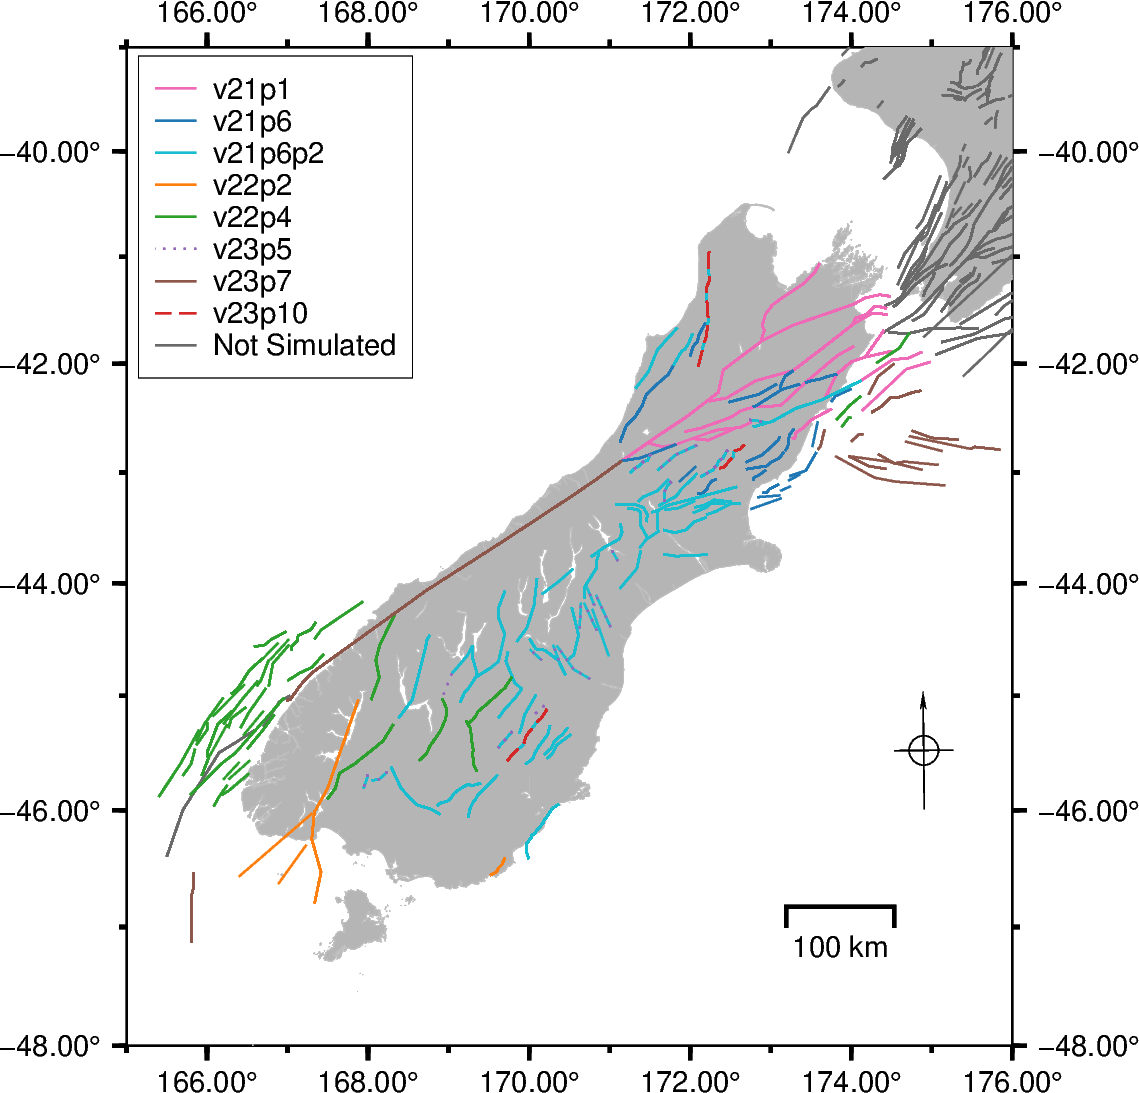

In [18]:
plot_using_mapdata = False

if plot_using_mapdata == True:
    # loading the mapdata
    map_data = (
        plotting.NZMapData.load(map_data_ffp) if map_data_ffp is not None else None
    )
else:
    map_data = None

fig = gen_region_fig(
    title=None,
    region=[165, 176, -48, -39],
    projection="M7.5c",
    map_data=map_data,
    plot_topo=True,
    plot_roads=False,
    plot_highways=False,
    plot_kwargs={
        "highway_pen_width": 0.1,
        "coastline_pen_width": 0.001,
        "topo_cmap": "gray",  # etopo1 geo
        "topo_cmap_min": 0,
        "topo_cmap_max": 3700,
        "topo_cmap_inc": 250,
        "topo_cmap_reverse": True,
    },
    config_options=dict(
        MAP_FRAME_TYPE="graph",
        FORMAT_GEO_MAP="ddd.xx",
        MAP_GRID_PEN="0.5p,gray",
        MAP_TICK_PEN_PRIMARY="1p,black",
        MAP_FRAME_PEN="thinner,black",
        MAP_FRAME_AXES="WSEN",
        FONT_ANNOT_PRIMARY="7p,Helvetica,black",
        FONT_LABEL="7p",  # Font size for axis labels
        FONT_TITLE="9p",  # Font size for the title
    ),
)
fig.basemap(map_scale="jBR+w100k+o1c/1c", rose="JBR+w1.0c+o0.5c/2c")

for fault_name in NSHM_faults_all:
    if fault_name in All_Faults:
        continue
    fault_object = sha.nshm_2010.get_fault_objects(flt_erf[fault_name])
    for i in range(len(fault_object.planes)):
        ##create a shapely geometry for the plane
        ##(see https://github.com/ucgmsim/source_modelling/blob/ecf02f6d5d2fee4e8b8c5e9a1c3449a2d84789ec/source_modelling/sources.py#L403 )
        subfault_polygon = fault_object.planes[i].geometry
        
        long_trace, lat_trace = zip(*flt_erf[fault_name].trace.tolist())
        fig.plot(x=long_trace, y=lat_trace, pen="0.5p,dimgray")
    

version_color_code = {
    "v21p1": ('#ef69b7', 'solid'),
    "v21p6": ('#1f77b4', 'solid'),
    "v21p6p2": ('#17becf', 'solid'),
    "v22p2": ('#ff7f0e', 'solid'),
    "v22p4": ('#2ca02c', 'solid'),
    "v23p5": ('#9467bd', '.'),
    "v23p7": ('#8c564b', 'solid'),
    "v23p10": ("#d62728", '-'),
}

for v in versions:
    faults = list(S_DATA[v].keys())
    for fault_name in faults:
        fault_object = sha.nshm_2010.get_fault_objects(flt_erf[fault_name])
        for i in range(len(fault_object.planes)):
            ##create a shapely geometry for the plane
            ##(see https://github.com/ucgmsim/source_modelling/blob/ecf02f6d5d2fee4e8b8c5e9a1c3449a2d84789ec/source_modelling/sources.py#L403 )
            subfault_polygon = fault_object.planes[i].geometry
            long_trace, lat_trace = zip(*flt_erf[fault_name].trace.tolist())
            fig.plot(x=long_trace, y=lat_trace, pen=f"0.5p,{version_color_code[v][0]},{version_color_code[v][1]}")


# create a legend for versions
for v in versions:
    fig.plot(
        x=[190, 200],
        y=[-40, -40],
        pen=f"0.5p,{version_color_code[v][0]},{version_color_code[v][1]}",
        label=v,
    )
fig.plot(x=[190, 200], y=[-40, -40], pen="0.5p,dimgray", label="Not Simulated")
fig.legend(position="JTL+o0.1c/-2.8c+jBL", box="+gwhite+p0.1p,black")


fig.show()

fig.savefig(plot_dir / 'fault_traces_with_versions.png', dpi=900)

# Cecks

## 1- Check topography models of different versions

In [19]:
versions_topo_types_table = all_data_df.pivot_table(index='Version', columns='vm_topo_type', aggfunc='size', fill_value=0)
versions_topo_types_table = versions_topo_types_table[['BULLDOZED', 'SQUASHED_TAPERED', 'Missing_VM']].copy()
versions_topo_types_table = versions_topo_types_table.reindex(versions)
versions_topo_types_table

vm_topo_type,BULLDOZED,SQUASHED_TAPERED,Missing_VM
Version,,,
v21p1,0,674,0
v21p6,559,0,0
v21p6p2,302,0,1368
v22p2,162,0,0
v22p4,1043,0,0
v23p5,425,0,0
v23p7,548,0,0
v23p10,0,100,0


In [20]:
versions_topo_types_table = versions_topo_types_table.reset_index()

# Export summary_df as LaTeX table
latex_table = versions_topo_types_table.to_latex(index=False)
print(latex_table)

\begin{tabular}{lrrr}
\toprule
Version & BULLDOZED & SQUASHED_TAPERED & Missing_VM \\
\midrule
v21p1 & 0 & 674 & 0 \\
v21p6 & 559 & 0 & 0 \\
v21p6p2 & 302 & 0 & 1368 \\
v22p2 & 162 & 0 & 0 \\
v22p4 & 1043 & 0 & 0 \\
v23p5 & 425 & 0 & 0 \\
v23p7 & 548 & 0 & 0 \\
v23p10 & 0 & 100 & 0 \\
\bottomrule
\end{tabular}



## 2- Checking for missing source files

In [21]:
mask = all_data_df.apply(lambda row: row.str.contains('Missing_Source_File').any(), axis=1)
filtered_df = all_data_df[mask]
filtered_df1 = filtered_df.pivot_table(index='Fault', columns='Version', aggfunc='size', fill_value=0)
filtered_df1

Version,v21p6p2
Fault,
AhuririR,30
Akatore,33
Albury,21
Ashley,31
Billys,29
BlueLk,29
BlueMtn,31
Brothers,26
Browning,24


## 3- Checking for missing VMs

In [22]:
mask = all_data_df.apply(lambda row: row.str.contains('Missing_VM').any(), axis=1)
filtered_df = all_data_df[mask]
filtered_df2 = filtered_df.pivot_table(index='Fault', columns='Version', aggfunc='size', fill_value=0)
filtered_df2

Version,v21p6p2
Fault,
AhuririR,30
Akatore,33
Albury,21
Ashley,31
Billys,29
BlueLk,29
BlueMtn,31
Brothers,26
Browning,24


In [23]:
# Export summary_df as LaTeX table
filtered_df2.reset_index(inplace=True)
latex_table = filtered_df2.to_latex(index=False)
print(latex_table)

\begin{tabular}{lr}
\toprule
Fault & v21p6p2 \\
\midrule
AhuririR & 30 \\
Akatore & 33 \\
Albury & 21 \\
Ashley & 31 \\
Billys & 29 \\
BlueLk & 29 \\
BlueMtn & 31 \\
Brothers & 26 \\
Browning & 24 \\
CardronaN & 27 \\
Cheeseman & 24 \\
Cust & 27 \\
Dalgety & 23 \\
DoubleHill & 28 \\
Dryburgh & 24 \\
FernGully & 29 \\
FoxPk & 29 \\
Gimmerburn & 31 \\
Grandview & 27 \\
Harper & 27 \\
Hokonui & 35 \\
Hororata & 30 \\
Hunter & 29 \\
HuttPeelNorth & 29 \\
HuttPeelSouth & 28 \\
Hyde & 30 \\
IrishmanC & 29 \\
Kirkliston & 31 \\
LindisP & 26 \\
LkHeron & 29 \\
LongVlly & 23 \\
MoonlightNth & 35 \\
NorthBranch & 27 \\
Opawa & 25 \\
Ostler & 34 \\
Otematata & 19 \\
Pisa & 30 \\
QuartzCk & 15 \\
Raggedy & 28 \\
Rakaia & 28 \\
Springbank & 27 \\
Springfield & 26 \\
Spylaw & 31 \\
Stonewall & 21 \\
TaieriR & 30 \\
Takitimu1 & 20 \\
Takitimu2 & 22 \\
Torlesse & 29 \\
Waipiata & 33 \\
Waitangi & 19 \\
\bottomrule
\end{tabular}



## 4- Find fualts with redundant versions

In [24]:
dup_faults = []
for fualt in All_Faults:
    temp_df = all_data_df[all_data_df['Fault'] == fualt]
    if temp_df['Version'].nunique() > 1:
        dup_faults.append(fualt)
dup_faults

dup_faults_df = pd.DataFrame(index=dup_faults, columns=versions)
for fault in dup_faults:
    temp_df = all_data_df[all_data_df['Fault'] == fault]
    for v in versions:
        if v in temp_df['Version'].values:
            dup_faults_df.loc[fault, v] = len(temp_df[temp_df['Version'] == v])
        else:
            dup_faults_df.loc[fault, v] = ""
dup_faults_df
        

,v21p1,v21p6,v21p6p2,v22p2,v22p4,v23p5,v23p7,v23p10
Albury,,,21,,,21,,
Brothers,,,26,,,26,,
Browning,,,24,,,24,,
Cheeseman,,,24,,,24,,
Dalgety,,,23,,,23,,
Dryburgh,,,24,,,24,,
Esk,,,26,,,26,,
Hanmer,,,20,,,20,,
LongVlly,,,23,,,23,,
Opawa,,,25,,,25,,


In [25]:
# Export summary_df as LaTeX table
dup_faults_df.reset_index(inplace=True)
latex_table = dup_faults_df.to_latex(index=False)
print(latex_table)

\begin{tabular}{lllllllll}
\toprule
index & v21p1 & v21p6 & v21p6p2 & v22p2 & v22p4 & v23p5 & v23p7 & v23p10 \\
\midrule
Albury &  &  & 21 &  &  & 21 &  &  \\
Brothers &  &  & 26 &  &  & 26 &  &  \\
Browning &  &  & 24 &  &  & 24 &  &  \\
Cheeseman &  &  & 24 &  &  & 24 &  &  \\
Dalgety &  &  & 23 &  &  & 23 &  &  \\
Dryburgh &  &  & 24 &  &  & 24 &  &  \\
Esk &  &  & 26 &  &  & 26 &  &  \\
Hanmer &  &  & 20 &  &  & 20 &  &  \\
LongVlly &  &  & 23 &  &  & 23 &  &  \\
Opawa &  &  & 25 &  &  & 25 &  &  \\
Otematata &  &  & 19 &  &  & 19 &  &  \\
Poulter &  &  & 27 &  &  & 27 &  &  \\
QuartzCk &  &  & 15 &  &  & 15 &  &  \\
Stonewall &  &  & 21 &  &  & 21 &  &  \\
Takitimu1 &  &  & 20 &  &  & 20 &  &  \\
Takitimu2 &  &  & 22 &  &  & 22 &  &  \\
Waipiata &  &  & 33 &  &  &  &  & 33 \\
Waitangi &  &  & 19 &  &  & 19 &  &  \\
Waitohi &  &  & 28 &  &  &  &  & 28 \\
WhiteCk &  &  & 39 &  &  &  &  & 39 \\
\bottomrule
\end{tabular}



## 5- Find faults with redundant versions but with non-unique VM

In [26]:
for fualt in All_Faults:
    temp_df = all_data_df[all_data_df['Fault'] == fualt]
    if temp_df['Version'].nunique() > 1:
        topo_types = list(temp_df['vm_topo_type'].unique())
        if "Missing_VM" in topo_types:
            topo_types = ["BULLDOZED" if t == "Missing_VM" else t for t in topo_types]
        topo_types = list(set(topo_types))
        if len(topo_types) > 1:
            print(fualt)

Waipiata
Waitohi
WhiteCk


## 6- Check if faults geometry is consistent with NZ NSHM

## 6-1- Check all realizations have the same lenght as  NZ NSHM

In [27]:
for fault in All_Faults:
    temp_df = all_data_df[all_data_df['Fault'] == fault].copy()
    temp_df = temp_df[temp_df['type'] != 'Missing_Source_File'].copy()
    if len(temp_df['length'].unique()) > 1:
        print(f"Fault {fault} has realizations with different length values: {list(temp_df['length'].unique())}")
    else:
        fault_object = sha.nshm_2010.get_fault_objects(flt_erf[fault])
        target_length = fault_object.length
        unique_lengths = temp_df['length'].unique()
        if len(unique_lengths) == 0:
            continue
        else:
            rels_length = unique_lengths[0]
            if round(rels_length, 0) != round(target_length, 0):
                print(f"The length of Fault {fault} simulations ({rels_length}) is different from target length {target_length}")

The length of Fault AlpineF2K simulations (412.5) is different from target length 413.18877115394366
The length of Fault AlpineK2T simulations (192.5) is different from target length 192.56371132732494
The length of Fault AwatNEVer simulations (118.5) is different from target length 118.52955659788023
The length of Fault BrunAnt simulations (58.7) is different from target length 58.49678982519104
The length of Fault Caswell5 simulations (44.5) is different from target length 44.68610792213173
The length of Fault MS01 simulations (34.5) is different from target length 34.54347865805473
The length of Fault Maimai simulations (39.5) is different from target length 39.441402268557425
The length of Fault NMFZK2 simulations (30.5) is different from target length 30.558871602430756
The length of Fault Waipiata simulations (64.5) is different from target length 64.58417369508587


## 6-2- Check all realizations have the same width as  NZ NSHM

In [28]:
temp_df = all_data_df.copy()
temp_df = temp_df[temp_df['type'] != 'Missing_Source_File'].copy()

temp_faults = temp_df['Fault'].unique()
len(temp_faults)

127

In [29]:
162-127

35

In [30]:
different_width_faults_df = pd.DataFrame(columns=['Fault', 'Rels. Width', 'NSHM Width'])
for fault in All_Faults:
    temp_df = all_data_df[all_data_df['Fault'] == fault].copy()
    temp_df = temp_df[temp_df['type'] != 'Missing_Source_File'].copy()
    if len(temp_df['width_subfault_0'].unique()) > 1:
        print(f"Fault {fault} has realizations with different width values: {list(temp_df['width_subfault_0'].unique())}")
    fault_object = sha.nshm_2010.get_fault_objects(flt_erf[fault])
    target_width = fault_object.width
    unique_width = temp_df['width_subfault_0'].unique()
    if len(unique_width) == 0:
        continue
    else:
        rels_width = unique_width[0]
        different_width_faults_df.loc[len(different_width_faults_df)] = [fault, rels_width, target_width]

different_width_faults_df['Width_Difference'] = round(different_width_faults_df['Rels. Width'] - different_width_faults_df['NSHM Width'], 0)
print(f"Different batches of width differences: {different_width_faults_df['Width_Difference'].unique()} ")
len(list(different_width_faults_df[different_width_faults_df['Width_Difference'] == 7].Fault))

Different batches of width differences: [3. 4. 7.] 


9

<Axes: >

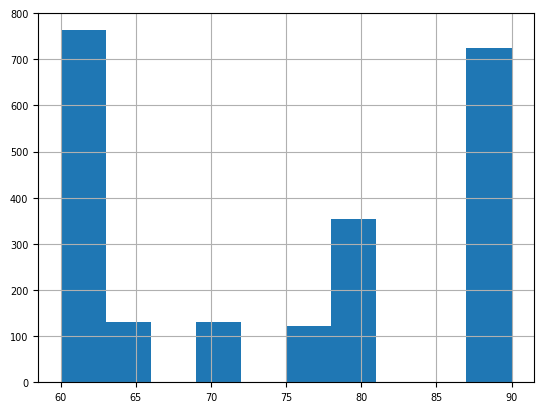

In [31]:

all_data_df[all_data_df['Fault'].isin(list(different_width_faults_df[different_width_faults_df['Width_Difference'] == 3].Fault))]['dip'].hist()

<Axes: >

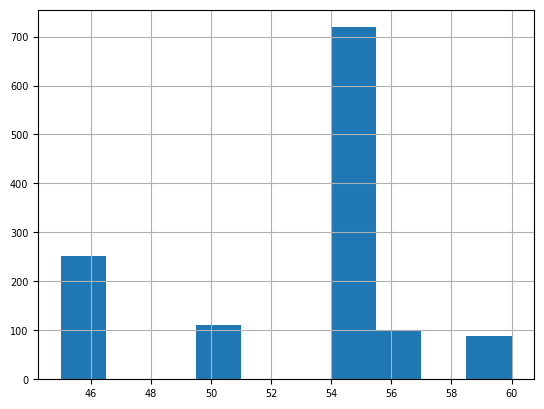

In [32]:

all_data_df[all_data_df['Fault'].isin(list(different_width_faults_df[different_width_faults_df['Width_Difference'] == 4].Fault))]['dip'].hist()

<Axes: >

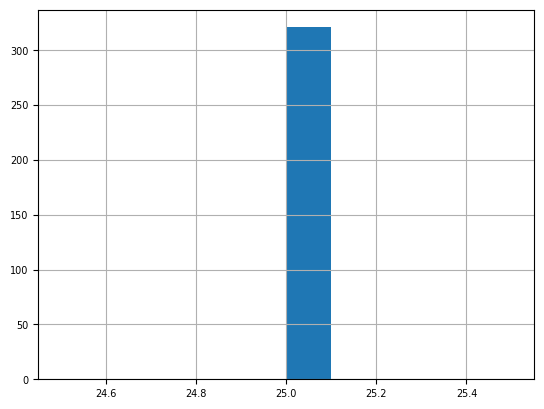

In [33]:

all_data_df[all_data_df['Fault'].isin(list(different_width_faults_df[different_width_faults_df['Width_Difference'] == 7].Fault))]['dip'].hist()

## 6- Check if mag. is consistent with mag. from scaling relations

In [34]:
temp_df = all_data_df[['Version', 'Fault', 'magnitude_from_area', 'magnitude_subfault_0']].copy()
temp_df = temp_df.dropna()
temp_df['magnitude_from_area'] = temp_df['magnitude_from_area'].astype(float)
temp_df['magnitude_subfault_0'] = temp_df['magnitude_subfault_0'].astype(float)
mask = temp_df['magnitude_from_area'].round(1).eq(temp_df['magnitude_subfault_0'].round(1))
temp_df2 = temp_df[~mask].drop_duplicates(['Version', 'Fault'])
temp_df2

,Version,Fault,magnitude_from_area,magnitude_subfault_0
484,v21p1,ClarenceSW,7.055187,7.044658
1655,v21p6p2,HopeConwayOS,7.252831,7.246780
4520,v23p5,QuartzCk,6.258518,6.246806


## 7- Investigating the magnitude distribution

In [35]:

# --- helpers ---
def mad_1d(x):
    x = np.asarray(x, float)
    if x.size == 0: return np.nan
    med = np.median(x)
    return 1.4826 * np.median(np.abs(x - med))  # consistent w/ normal

def target_sigma_from_row(tect_type, rake):
    # Your logic preserved:
    if tect_type in ['ACTIVE_SHALLOW', 'VOLCANIC']:
        return util.mw_sigma_leonard(rake)
    else:
        return util.mw_sigma_skarlatoudis()

def quantile_drift(x, loc, scale, qs=(0.1, 0.25, 0.5, 0.75, 0.9)):
    if len(x) == 0:
        return {f"qd_{int(q*100)}": np.nan for q in qs} | {"qd_max": np.nan}
    emp = np.quantile(x, qs)
    tgt = norm.ppf(qs, loc=loc, scale=scale)
    drifts = np.abs(emp - tgt)
    out = {f"qd_{int(q*100)}": d for q,d in zip(qs, drifts)}
    out["qd_max"] = drifts.max()
    return out

# --- build tidy summary for each (Fault, Version) ---
rows = []
df = all_data_df.copy()
df = df[df['type'] != 'Missing_Source_File']

for (fault, vers), g in df.groupby(['Fault', 'Version']):
    mags = g['magnitude'].dropna().astype(float).values
    n = len(mags)
    unique_count = len(np.unique(mags))
    degenerate = (n <= 1) or (unique_count == 1) or (np.nanstd(mags) == 0)

    # target per group (assumes constant per (fault,version) in your data)
    target_mag = float(g['magnitude_from_area'].iloc[0])
    rake = g['rake'].iloc[0]
    tect_type = g['tect_type'].iloc[0]
    target_sigma = float(target_sigma_from_row(tect_type, rake))

    mean = float(np.nanmean(mags)) if n else np.nan
    std = float(np.nanstd(mags, ddof=1)) if n > 1 else (0.0 if n==1 else np.nan)
    median = float(np.nanmedian(mags)) if n else np.nan
    mad = float(mad_1d(mags))

    # coverage wrt target
    if n:
        within_1s = float(np.mean(np.abs(mags - target_mag) <= 1.0 * target_sigma))
        within_2s = float(np.mean(np.abs(mags - target_mag) <= 2.0 * target_sigma))
        minv, maxv = float(np.min(mags)), float(np.max(mags))
    else:
        within_1s = within_2s = minv = maxv = np.nan

    # distances/effect sizes (avoid p-values)
    if n >= 2 and not degenerate:
        cdf = lambda x: norm.cdf(x, loc=target_mag, scale=target_sigma)
        ks_res = kstest(mags, cdf)              # ks_res.statistic is D
        D = float(ks_res.statistic)
        cvm = float(cramervonmises(mags, cdf).statistic)
    else:
        D = np.nan
        cvm = np.nan

    qdr = quantile_drift(mags, target_mag, target_sigma)

    row = dict(
        Fault=fault, Version=vers, n=n, unique_count=unique_count, degenerate=bool(degenerate),
        mean=mean, std=std, median=median, MAD=mad,
        target_mean=target_mag, target_sigma=target_sigma,
        mean_shift_std = (mean - target_mag) / target_sigma if n else np.nan,
        std_ratio = (std / target_sigma) if (n and target_sigma>0) else np.nan,
        within_1sigma=within_1s, within_2sigma=within_2s,
        min=minv, max=maxv, KS_D=D, CvM=cvm,
    )
    row.update(qdr)
    rows.append(row)

summary = pd.DataFrame(rows)
summary = summary.sort_values(["Fault","Version"]).reset_index(drop=True)

# creat flags 
summary["flag_small_n"]   = summary["n"] < 14
summary["flag_degenerate"]= summary["degenerate"]
summary["flag_mean_shift"]= summary["mean_shift_std"].abs() > 1.0          # >1σ mean shift       -confdence interval
summary["flag_std_ratio"] = (summary["std_ratio"] < 0.67) | (summary["std_ratio"] > 1.5)
summary["flag_low_cov1s"] = summary["within_1sigma"] < 0.55               # expected ~0.68, allow slack
summary["flag_low_cov2s"] = summary["within_2sigma"] < 0.85               # expected ~0.95, allow slack
summary["flag_large_KS"]  = summary["KS_D"] > 0.20
summary["flag_qd_max"]    = summary["qd_max"] > 0.25                       # 0.25 Mw drift at any key quantile



### 7-1- Small number of realizations

In [36]:
control_number = 10  # minimum number of acceptable realizations 

print(f"This control is set to check if the number of realizations is less than {control_number}.")

summary["flag_small_n"]   = summary["n"] < 14

if len(summary[summary["flag_small_n"]]) > 0:
    summary[summary["flag_small_n"]]
else:
    print("No small n issues found.")

This control is set to check if the number of realizations is less than 10.
No small n issues found.


### 7-2- Degenrated magnitudes

In [37]:
print(f"This control is set to check if the realizations have degenerated magnitudes.")
print("With Degernated magnitudes, we mean all the realizations have the same magnitude value.")

summary["flag_degenerate"]= summary["degenerate"]

summary[summary["flag_degenerate"]]

This control is set to check if the realizations have degenerated magnitudes.
With Degernated magnitudes, we mean all the realizations have the same magnitude value.


,Fault,Version,n,unique_count,degenerate,mean,std,median,MAD,target_mean,...,qd_90,qd_max,flag_small_n,flag_degenerate,flag_mean_shift,flag_std_ratio,flag_low_cov1s,flag_low_cov2s,flag_large_KS,flag_qd_max
1,AlpineF2K,v23p7,47,1,True,7.848589,3.591123e-15,7.848589,0.0,7.848462,...,0.333076,0.333330,False,True,False,True,False,False,False,True
12,CBalleny,v23p7,32,1,True,7.082217,0.000000e+00,7.082217,0.0,7.081995,...,0.384244,0.384687,False,True,False,True,False,False,False,True
68,MS04,v23p7,31,1,True,7.012458,9.028600e-16,7.012458,0.0,7.012669,...,0.384676,0.384676,False,True,False,True,False,False,False,True
70,MS09,v23p7,27,1,True,6.435435,9.050976e-16,6.435435,0.0,6.434249,...,0.383280,0.385651,False,True,False,True,False,False,False,True
76,NMFZ1819,v23p7,29,1,True,6.937778,9.038996e-16,6.937778,0.0,6.937919,...,0.384606,0.384606,False,True,False,True,False,False,False,True
77,NMFZ4647,v23p7,30,1,True,6.951692,9.033621e-16,6.951692,0.0,6.952017,...,0.384791,0.384791,False,True,False,True,False,False,False,True
78,NMFZB0,v23p7,31,1,True,7.009189,2.708580e-15,7.009189,0.0,7.008941,...,0.384217,0.384714,False,True,False,True,False,False,False,True
79,NMFZB1,v23p7,24,1,True,6.657703,9.072812e-16,6.657703,0.0,6.658393,...,0.385155,0.385155,False,True,False,True,False,False,False,True
80,NMFZB2,v23p7,31,1,True,7.043653,1.805720e-15,7.043653,0.0,7.043991,...,0.384804,0.384804,False,True,False,True,False,False,False,True
81,NMFZE1,v23p7,30,1,True,6.956979,1.806724e-15,6.956979,0.0,6.957320,...,0.384807,0.384807,False,True,False,True,False,False,False,True


### 7-3- Check deviation of mean value from target

In [38]:
print("This control is set to check if the mean value of realizations deviates from the target mean ")
print("by more than 0.5 times the target standard deviation.")

print("mean_shift_std = (mean − μ_target) / σ_target \n")

summary["flag_mean_shift"]= summary["mean_shift_std"].abs() > 0.5        # >0.5σ mean shift

if len(summary[summary["flag_mean_shift"]]) == 0:
    print("No significant mean shift issues found.")
else:
    summary[summary["flag_mean_shift"]]

This control is set to check if the mean value of realizations deviates from the target mean 
by more than 0.5 times the target standard deviation.
mean_shift_std = (mean − μ_target) / σ_target 

No significant mean shift issues found.


### 7-4- # Check std of realizations vs target std

In [39]:
print("This control is set to check if the standard deviation of realizations deviates from the target standard deviation ")

summary["flag_std_ratio"] = (summary["std_ratio"] < 0.67) | (summary["std_ratio"] > 1.5) # [0.67, 1.5] ~ 1 ± 0.5

if len(summary[summary["flag_std_ratio"]]) == 0:
    print("No significant std ratio issues found.")
else:
    print("Following source files have std ratio issues:")
    
summary[summary["flag_std_ratio"]]

This control is set to check if the standard deviation of realizations deviates from the target standard deviation 
Following source files have std ratio issues:


,Fault,Version,n,unique_count,degenerate,mean,std,median,MAD,target_mean,...,qd_90,qd_max,flag_small_n,flag_degenerate,flag_mean_shift,flag_std_ratio,flag_low_cov1s,flag_low_cov2s,flag_large_KS,flag_qd_max
0,Albury,v23p5,21,21,False,6.543810,1.835354e-01,6.562967,0.234455,6.536899,...,0.146696,0.153359,False,False,False,True,False,False,False,False
1,AlpineF2K,v23p7,47,1,True,7.848589,3.591123e-15,7.848589,0.000000,7.848462,...,0.333076,0.333330,False,True,False,True,False,False,False,True
2,AlpineK2T,v21p1,41,41,False,7.499792,1.335958e-01,7.503988,0.183571,7.517469,...,0.163987,0.183083,False,False,False,True,False,False,True,False
3,AlpineR,v22p4,38,38,False,7.332384,1.534591e-01,7.338698,0.212959,7.364198,...,0.158505,0.158505,False,False,False,True,False,False,False,False
4,AwatNEVer,v21p1,36,36,False,7.224625,1.589925e-01,7.231511,0.198801,7.264050,...,0.221104,0.221104,False,False,False,True,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127,Waitohi,v21p6p2,28,28,False,6.816640,1.747760e-01,6.854711,0.248386,6.862799,...,0.221520,0.221520,False,False,False,True,False,False,True,False
128,Waitohi,v23p10,28,1,True,6.863386,1.808953e-15,6.863386,0.000000,6.862799,...,0.383879,0.385052,False,True,False,True,False,False,False,True
129,WharaToCampB,v22p4,30,30,False,6.966859,1.439399e-01,7.001205,0.138402,6.967239,...,0.207209,0.207209,False,False,False,True,False,False,True,False
130,WhiteCk,v21p6p2,39,39,False,7.354179,1.708952e-01,7.373748,0.233310,7.410197,...,0.223409,0.223409,False,False,False,True,False,False,True,False


### 7-5- Use Q-Q plot to investigate the distribution

Version: v21p1, min: -0.99, max: 0.99, mean: -0.03, std: 0.55
Version: v21p6, min: -0.99, max: 0.99, mean: -0.00, std: 0.51
Version: v21p6p2, min: -0.99, max: 0.99, mean: -0.02, std: 0.56
Version: v22p2, min: -0.99, max: 0.99, mean: -0.07, std: 0.56
Version: v22p4, min: -0.99, max: 0.99, mean: -0.02, std: 0.53
Version: v23p5, min: -1.00, max: 0.99, mean: -0.05, std: 0.54
Version: v23p7, min: -0.00, max: 0.00, mean: 0.00, std: 0.00
Version: v23p10, min: -0.01, max: 0.00, mean: -0.00, std: 0.01


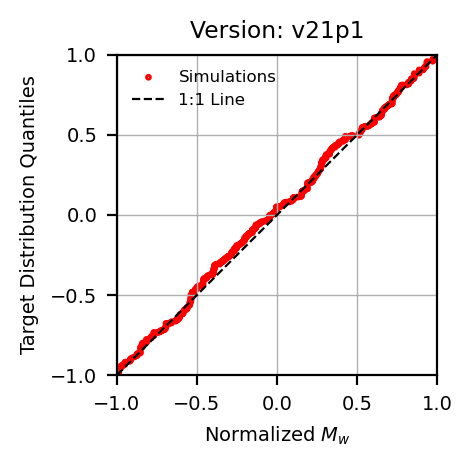

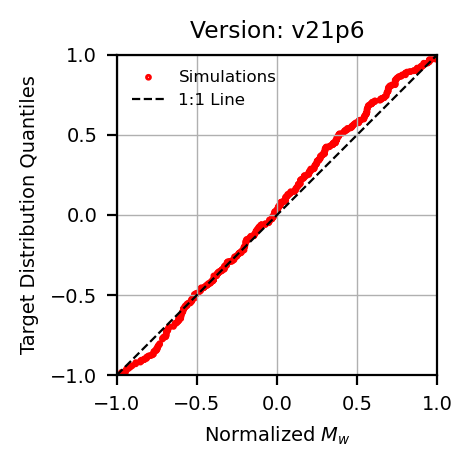

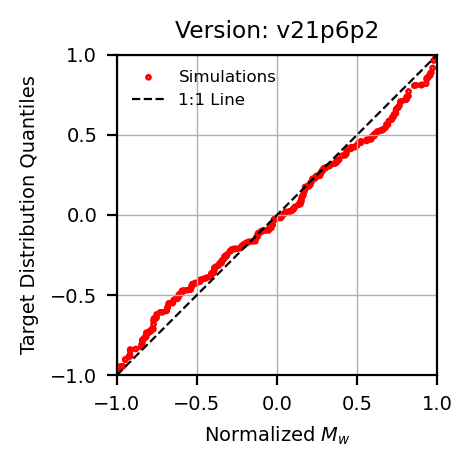

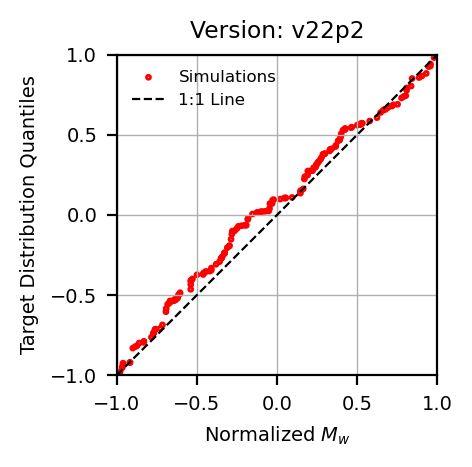

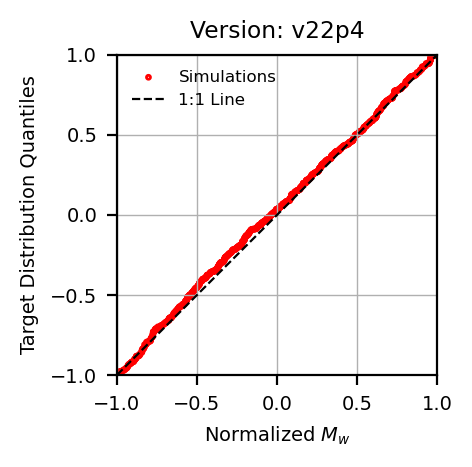

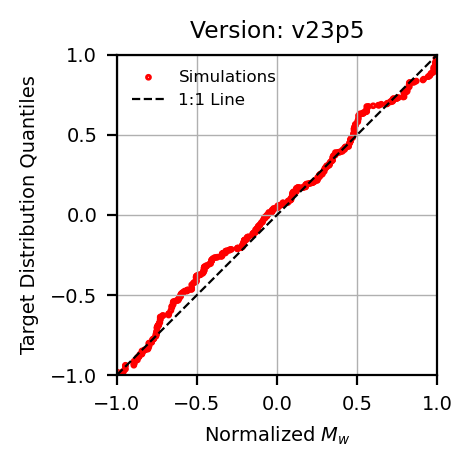

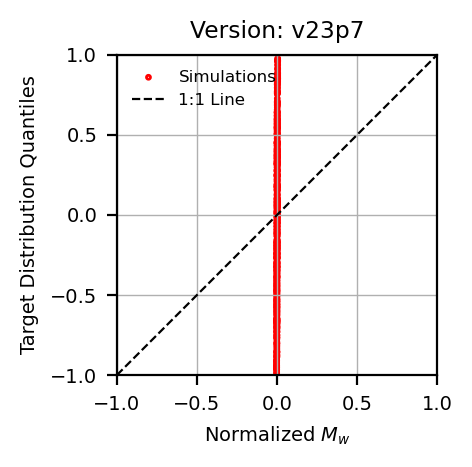

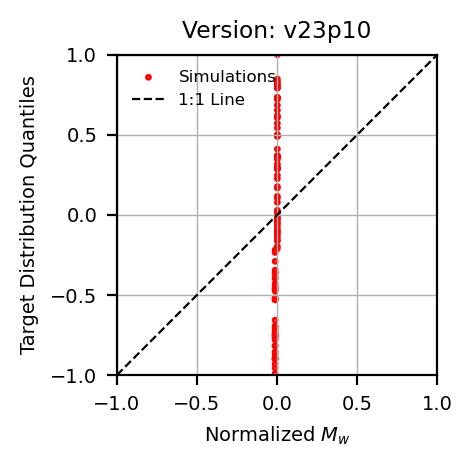

In [40]:
def target_sigma_from_row(tect_type, rake):
    # Your logic preserved:
    if tect_type in ['ACTIVE_SHALLOW', 'VOLCANIC']:
        return util.mw_sigma_leonard(rake)
    else:
        return util.mw_sigma_skarlatoudis()

df = all_data_df.copy()
df = df[df['type'] != 'Missing_Source_File']
df['target_sigma'] = df.apply(lambda row: target_sigma_from_row(row['tect_type'], row['rake']), axis=1)

# Calculate normalized hypocenter location
df['norm_mw'] = (df['magnitude'] - df['magnitude_from_area'])/ df['target_sigma']

for v in df['Version'].unique():
    temp_df = df[df['Version'] == v]
    print(f"Version: {v}, min: {temp_df['norm_mw'].min():0.2f}, max: {temp_df['norm_mw'].max():0.2f}, mean: {temp_df['norm_mw'].mean():0.2f}, std: {temp_df['norm_mw'].std():0.2f}")
    norm_hypos = sorted(list(temp_df['norm_mw'].dropna().values))
    n = len(norm_hypos)
    targ_dist = norm(loc=0, scale=1)
    targ_dist = truncnorm(a=-1, b=+1, scale=1)
    targ_dist_values = sorted(list(targ_dist.rvs(size=n)))
    
    fig, ax =plt.subplots(figsize=(6/2.54, 6/2.54), dpi=200)
    ax.scatter(norm_hypos, targ_dist_values, marker='o', s=2, facecolors='none', edgecolors='red', label='Simulations')
    ax.plot([-1, 1], [-1, 1], 'k--', lw=0.8, label='1:1 Line')
    ax.set_xlim([-1, 1])
    ax.set_ylim([-1, 1])
    ax.set_xticks(np.arange(-1, 1.1, 0.5))
    ax.set_yticks(np.arange(-1, 1.1, 0.5))
    ax.set_aspect('equal', 'box')
    ax.set_title(f"Version: {v}")
    ax.set_xlabel(r"Normalized $M_{w}$")
    ax.set_ylabel("Target Distribution Quantiles")
    ax.grid(linewidth=0.5)
    ax.legend(frameon=False, loc='upper left', fontsize=6)
    plt.tight_layout()
    
    fig.savefig(plot_dir / f'mw_qq_plot_{v}.png', dpi=300)
    
    

### 7-6- Check if seimic moment is consistent with moment magnitude

In [69]:
m0_to_mw(1e25)

6.6

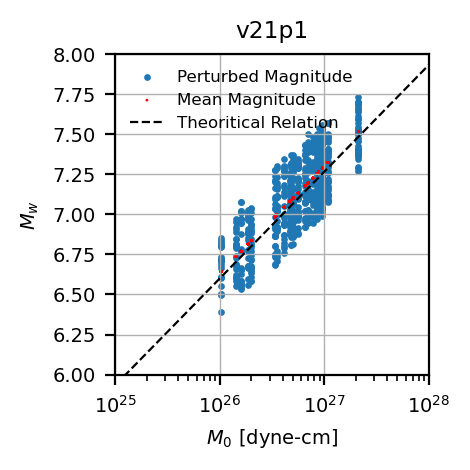

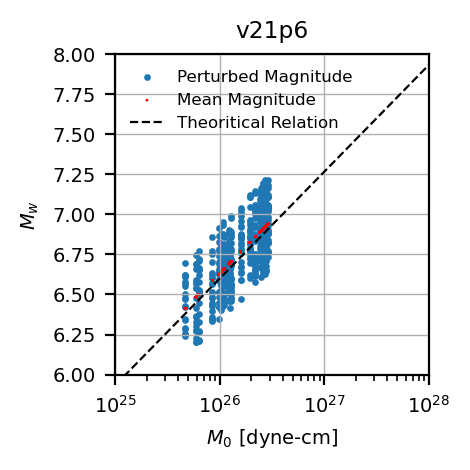

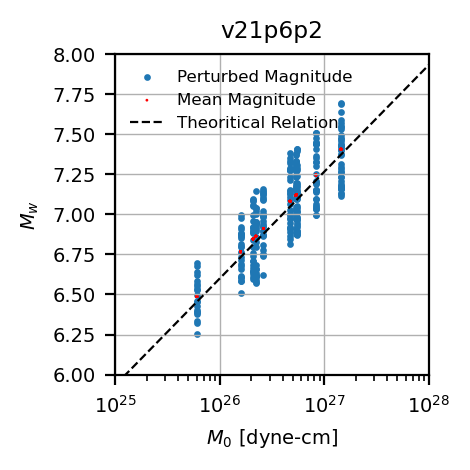

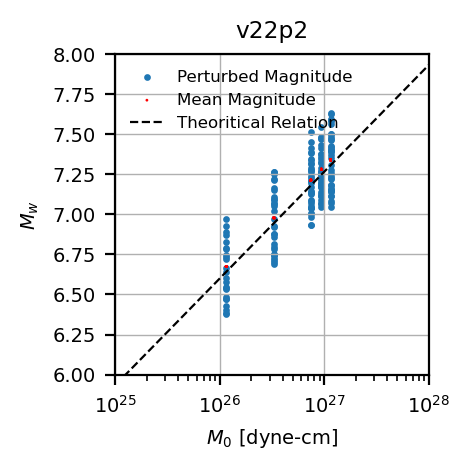

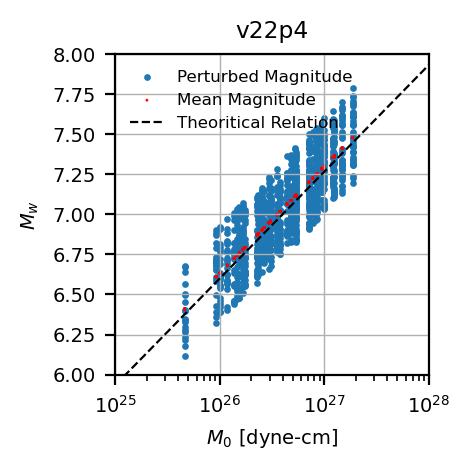

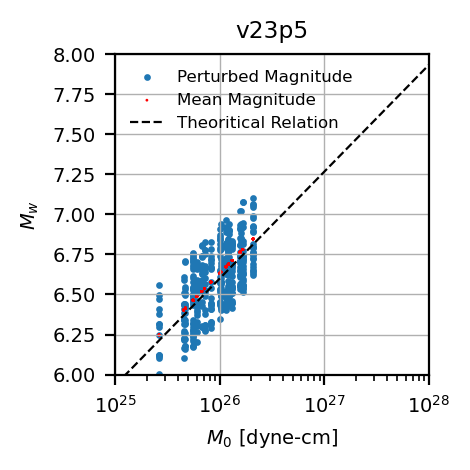

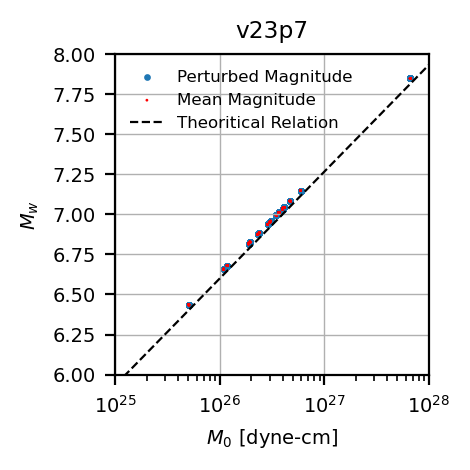

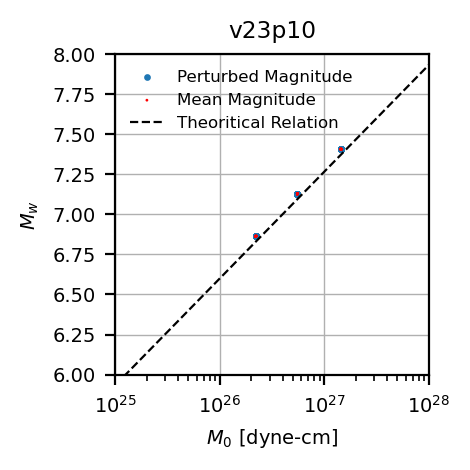

In [77]:
df = all_data_df[['Version', 'Fault', 'magnitude', 'moment', 'magnitude_subfault_0']].copy()
df['log_moment'] = np.log10(df['moment'].astype(float))

def m0_to_mw(m0):
    """
    m0: Seismic moment in dyne-cm
    returns: Moment magnitude
    𝑀𝑤=(2/3)(log10(𝑀 * 10^(-7)) - 9.1)
    """
    return (2/3) * (np.log10(m0/10000000) - 9.1)

for v in df['Version'].unique():
    fig, ax = plt.subplots(figsize=(6/2.54, 6/2.54), dpi=200)
    temp_df = df[df['Version'] == v]
    ax.scatter(temp_df['moment'].astype(float), temp_df['magnitude'].astype(float), s=2, label='Perturbed Magnitude')
    ax.scatter(temp_df['moment'].astype(float), temp_df['magnitude_subfault_0'].astype(float), s=1, facecolors='red', edgecolors='none', label='Mean Magnitude')
    ax.plot([1e25, 1e28], [m0_to_mw(1e25), m0_to_mw(1e28)], 'k--', lw=0.8, label='Theoritical Relation')
    ax.set_xscale('log')
    ax.set_yscale('linear')
    ax.set_ylabel(r"$M_{w}$")
    ax.set_xlabel(r"$M_{0}$ [dyne-cm]")
    ax.set_title(f"{v}")
    ax.set_ylim([6, 8])
    ax.set_xlim([1e25, 1e28])
    ax.grid(linewidth=0.5)
    ax.legend(frameon=False, loc='upper left', fontsize=6)
    plt.tight_layout()

## 8- Investigating the shypo distribution

### 8-1- A long strike direction

Version: v21p1, min: -0.24, max: 0.25, mean: -0.00, std: 0.11
Version: v21p6, min: -0.23, max: 0.25, mean: 0.00, std: 0.11
Version: v21p6p2, min: -0.21, max: 0.25, mean: 0.00, std: 0.11
Version: v22p2, min: -0.24, max: 0.24, mean: 0.01, std: 0.11
Version: v22p4, min: -0.50, max: 0.50, mean: -0.01, std: 0.22
Version: v23p5, min: -0.49, max: 0.49, mean: -0.02, std: 0.21
Version: v23p7, min: -0.49, max: 0.50, mean: -0.01, std: 0.23
Version: v23p10, min: -0.47, max: 0.47, mean: 0.01, std: 0.23


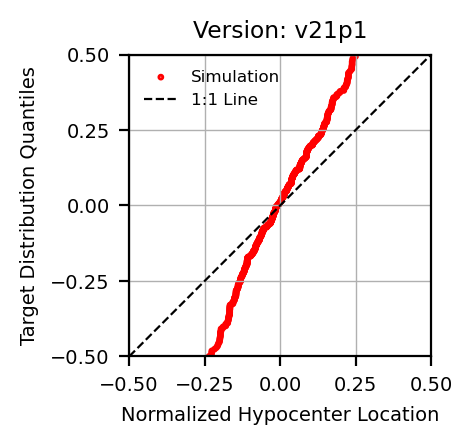

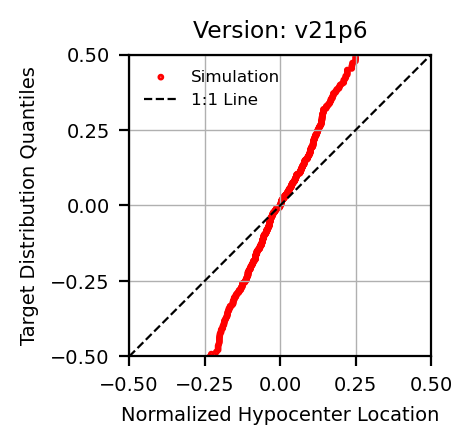

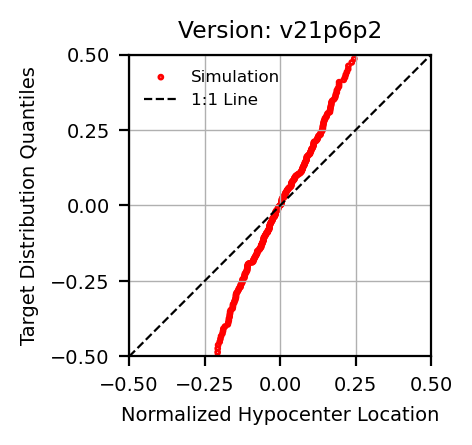

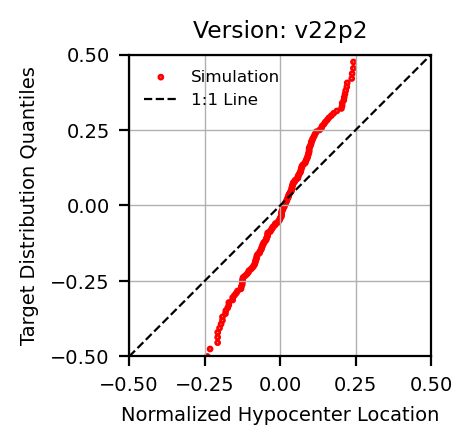

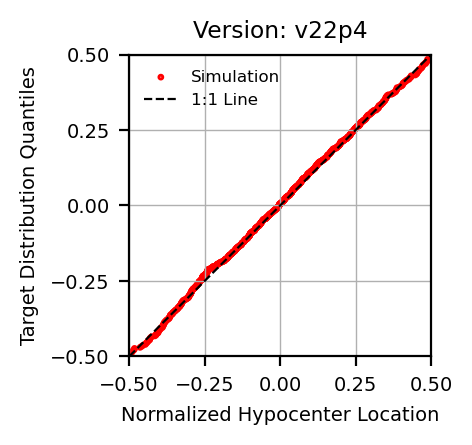

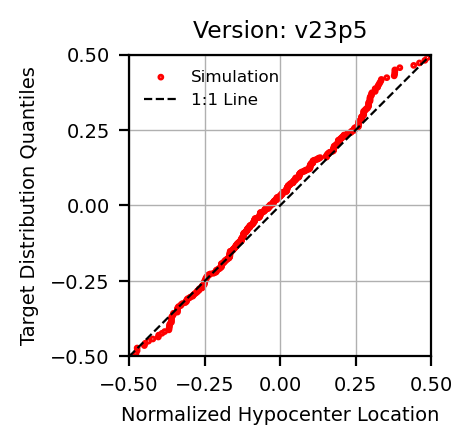

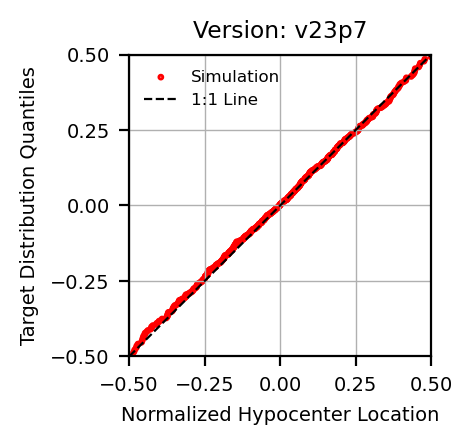

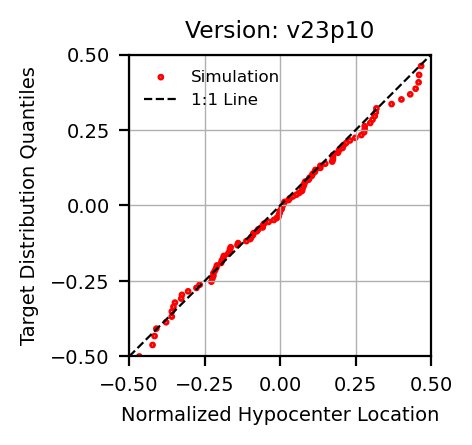

In [41]:
df = all_data_df.copy()
df = df[df['type'] != 'Missing_Source_File']

# Calculate normalized hypocenter location
df['rand_shyp'] = df['shypo'] / df['length']

for v in df['Version'].unique():
    temp_df = df[df['Version'] == v]
    print(f"Version: {v}, min: {temp_df['rand_shyp'].min():0.2f}, max: {temp_df['rand_shyp'].max():0.2f}, mean: {temp_df['rand_shyp'].mean():0.2f}, std: {temp_df['rand_shyp'].std():0.2f}")
    norm_hypos = sorted(list(temp_df['rand_shyp'].dropna().values))
    n = len(norm_hypos)
    probs = np.linspace(0, 1, n, endpoint=False)
    targ_dist = truncnorm(a=-2, b=+2, scale=0.25)
    targ_dist_values = targ_dist.ppf(probs)
    
    fig, ax =plt.subplots(figsize=(6/2.54, 6/2.54), dpi=200)
    ax.scatter(norm_hypos, targ_dist_values, marker='o', s=2, facecolors='none', edgecolors='red', label='Simulation')
    ax.plot([-0.5, 0.5], [-0.5, 0.5], 'k--', lw=0.8, label='1:1 Line')
    ax.set_xlim([-0.5, 0.5])
    ax.set_ylim([-0.5, 0.5])
    ax.set_xticks(np.arange(-0.5, 0.6, 0.25))
    ax.set_yticks(np.arange(-0.5, 0.6, 0.25))
    ax.set_aspect('equal', 'box')
    ax.set_title(f"Version: {v}")
    ax.set_xlabel("Normalized Hypocenter Location")
    ax.set_ylabel("Target Distribution Quantiles")
    ax.grid(linewidth=0.5)
    ax.legend(frameon=False, loc='upper left', fontsize=6)
    plt.tight_layout()
    
    fig.savefig(plot_dir / f'shypo_qq_plot_{v}.png', dpi=300)

### 8-2- Down dip direction

Version: v21p1, min: 0.06, max: 0.94, mean: 0.56, std: 0.18
Version: v21p6, min: 0.12, max: 0.96, mean: 0.55, std: 0.18
Version: v21p6p2, min: 0.10, max: 0.94, mean: 0.56, std: 0.17
Version: v22p2, min: 0.12, max: 0.94, mean: 0.55, std: 0.18
Version: v22p4, min: 0.04, max: 0.97, mean: 0.54, std: 0.18
Version: v23p5, min: 0.13, max: 0.95, mean: 0.53, std: 0.17
Version: v23p7, min: 0.08, max: 1.00, mean: 0.56, std: 0.17
Version: v23p10, min: 0.16, max: 0.91, mean: 0.55, std: 0.18


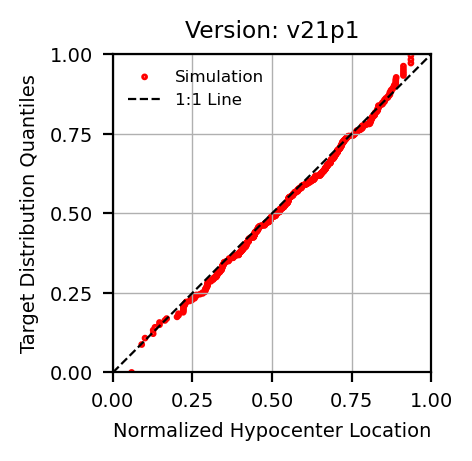

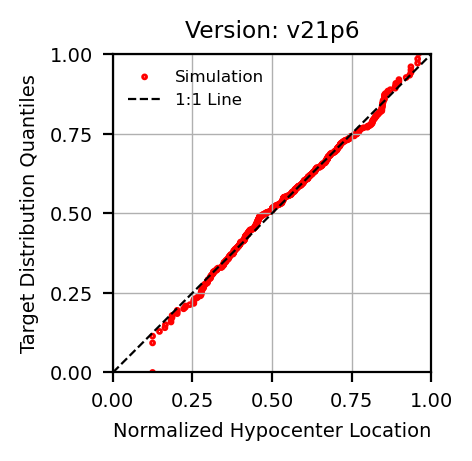

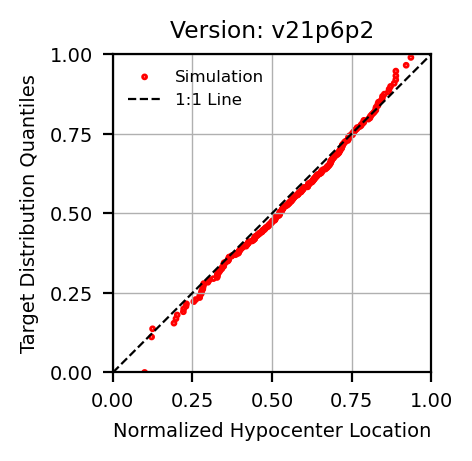

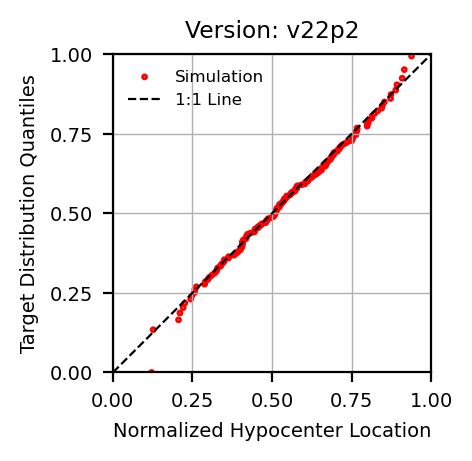

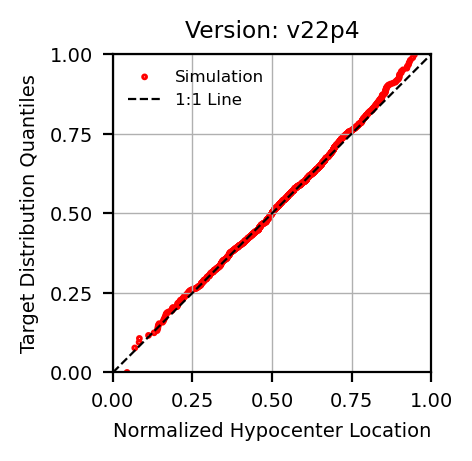

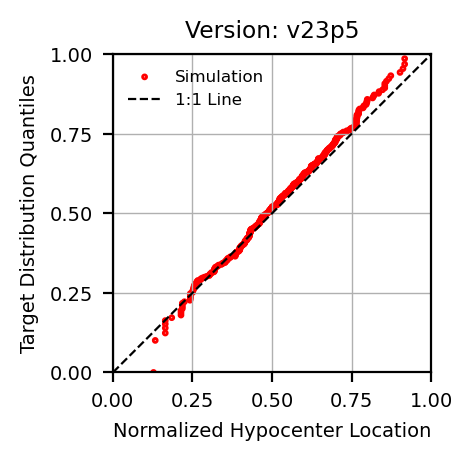

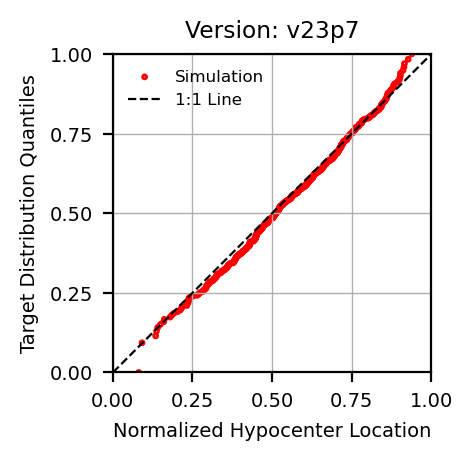

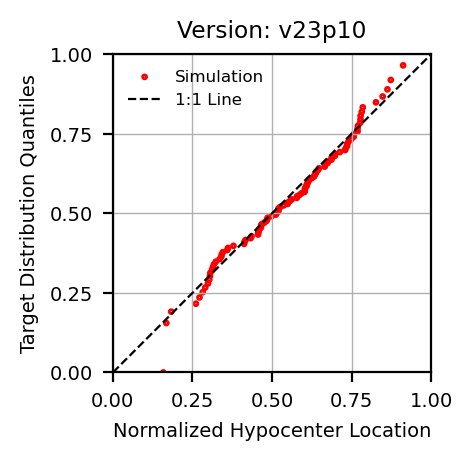

In [42]:
df = all_data_df.copy()
df = df[df['type'] != 'Missing_Source_File']

# Calculate normalized hypocenter location
df['rand_dhyp'] = df['dhypo'] / df['width_subfault_0'] 

for v in df['Version'].unique():
    temp_df = df[df['Version'] == v]
    print(f"Version: {v}, min: {temp_df['rand_dhyp'].min():0.2f}, max: {temp_df['rand_dhyp'].max():0.2f}, mean: {temp_df['rand_dhyp'].mean():0.2f}, std: {temp_df['rand_dhyp'].std():0.2f}")
    norm_hypos = np.sort(temp_df['rand_dhyp'].dropna().values)
    n = len(norm_hypos)
    probs = np.linspace(0, 1, n, endpoint=False)
    targ_dist = weibull_min(3.353, scale=0.612)
    targ_dist_values = targ_dist.ppf(probs)

    fig, ax =plt.subplots(figsize=(6/2.54, 6/2.54), dpi=200)
    ax.scatter(norm_hypos, targ_dist_values, marker='o', s=2, facecolors='none', edgecolors='red', label='Simulation')
    ax.plot([0, 1], [0, 1], 'k--', lw=0.8, label='1:1 Line')
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    ax.set_xticks(np.arange(0, 1.1, 0.25))
    ax.set_yticks(np.arange(0, 1.1, 0.25))
    ax.set_aspect('equal', 'box')
    ax.set_title(f"Version: {v}")
    ax.set_xlabel("Normalized Hypocenter Location")
    ax.set_ylabel("Target Distribution Quantiles")
    ax.grid(linewidth=0.5)
    ax.legend(frameon=False, loc='upper left', fontsize=6)
    plt.tight_layout()
    
    fig.savefig(plot_dir / f'dhypo_qq_plot_{v}.png', dpi=300)

### 8-3- Hypocenters Distribution Across Fault Surface

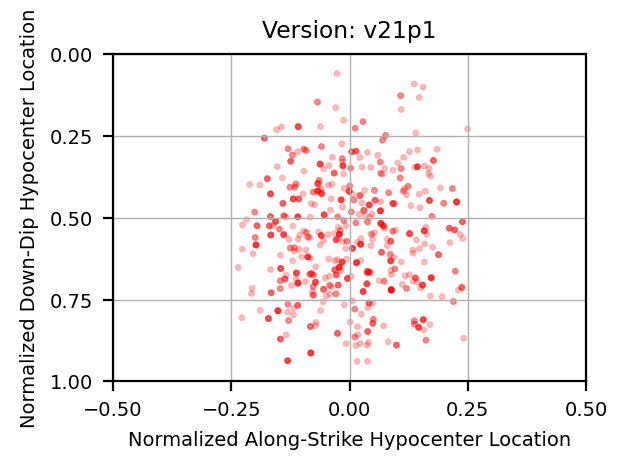

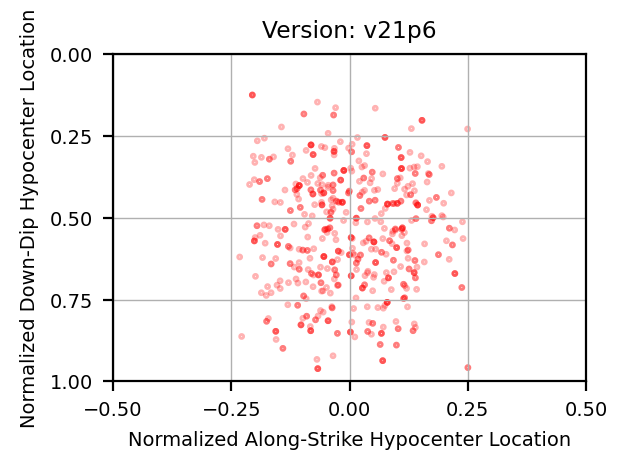

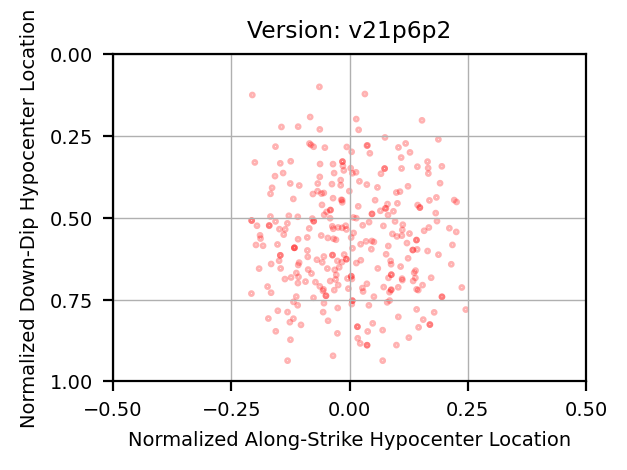

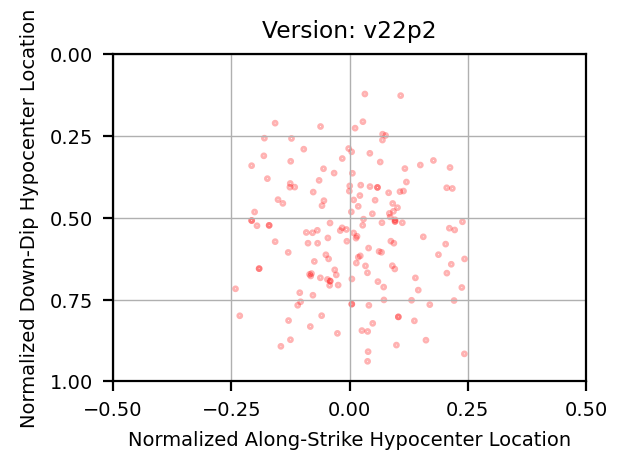

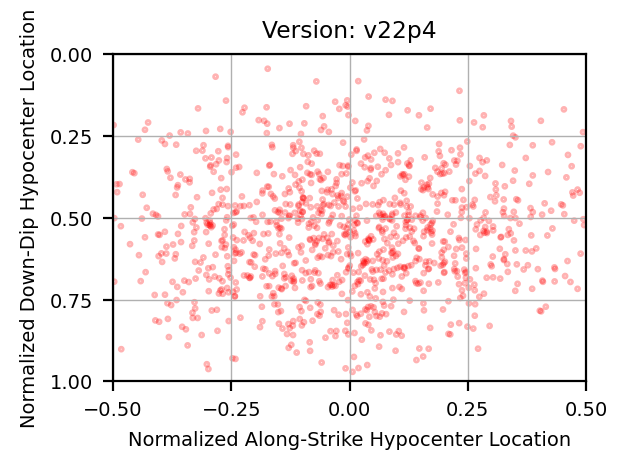

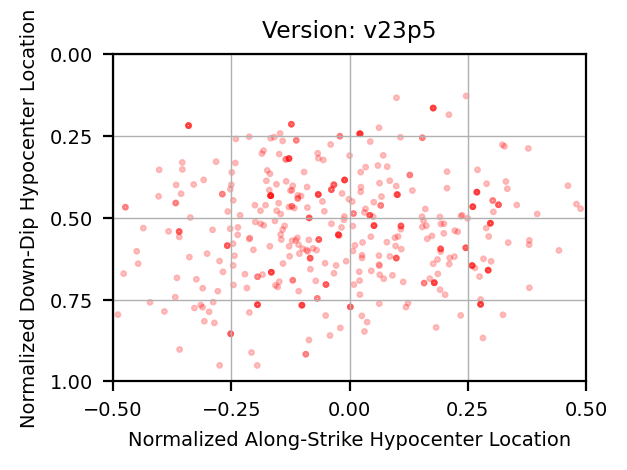

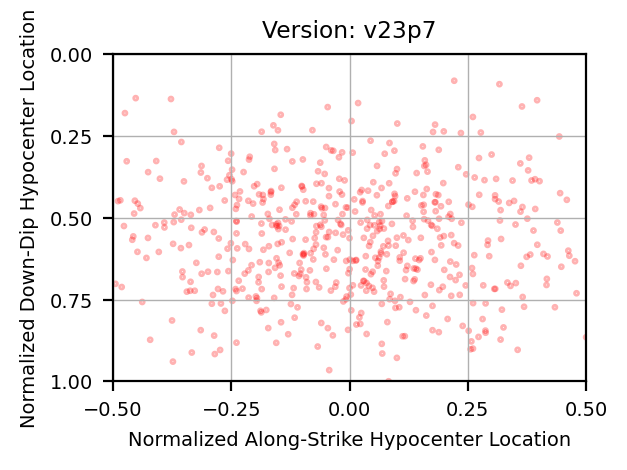

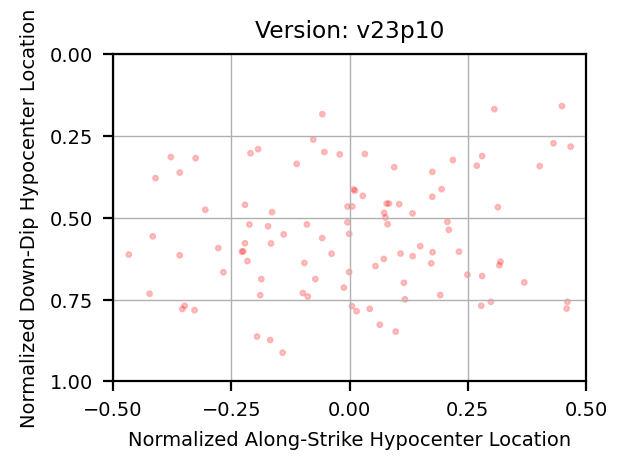

In [43]:
df = all_data_df.copy()
df = df[df['type'] != 'Missing_Source_File']

# Calculate normalized hypocenter location
df['rand_dhyp'] = df['dhypo'] / df['width_subfault_0'] 
df['rand_shyp'] = df['shypo'] / df['length']

for v in df['Version'].unique():
    temp_df = df[df['Version'] == v]
    fig, ax =plt.subplots(figsize=(8/2.54, 6/2.54), dpi=200)
    ax.scatter(temp_df['rand_shyp'], temp_df['rand_dhyp'], marker='o', s=2, facecolors='none', edgecolors='red', alpha=0.3)
    
    ax.set_xlim([-0.5, 0.5])
    ax.set_ylim([0, 1])
    ax.set_xticks(np.arange(-0.5, 0.51, 0.25))
    ax.set_yticks(np.arange(0, 1.1, 0.25))
    ax.invert_yaxis()
    # ax.set_aspect('equal', 'box')
    ax.set_title(f"Version: {v}")
    ax.set_xlabel("Normalized Along-Strike Hypocenter Location")
    ax.set_ylabel("Normalized Down-Dip Hypocenter Location")
    ax.grid(linewidth=0.5)
    plt.tight_layout()
    
    fig.savefig(plot_dir / f'shypo_dhypo_scatter_{v}.png', dpi=300)
    